🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 Starting IMPROVED Multi-Shape RL Painter Training...

KEY IMPROVEMENTS:
✓ Denser expert demonstrations (150+ points per outline)
✓ Shape-specific training configs (more epochs for complex shapes)
✓ Improved network architecture (deeper, more capacity)
✓ Better fill strategies (radial for star, parametric for heart)
✓ Adaptive reward weights per shape

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
Training on: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
✓ Policy network moved to cuda
✓ Shape config: BC epochs=100, RL episodes=1000, Demos=100

IMPROVED RL PAINTER - CIRCLE
🖥️  Device: cuda
🎯 Difficulty: ⭐
📊 Training: BC=100 epochs, RL=1000 episodes
🎨 Demos: 100 (improved strategies)

📚 Generating IMPROVED Expert Demonstrations for CIRCLE
✓ Generated 100 demonstrations
  Average trajectory length: 269 steps
  Density improvement: HIGH

✓ Collected 26800 state-action pairs

🎓 Phase 1: Behavioral Cloning (Adaptive Training)
Dataset s

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/improved_multi_shape_painter.png'

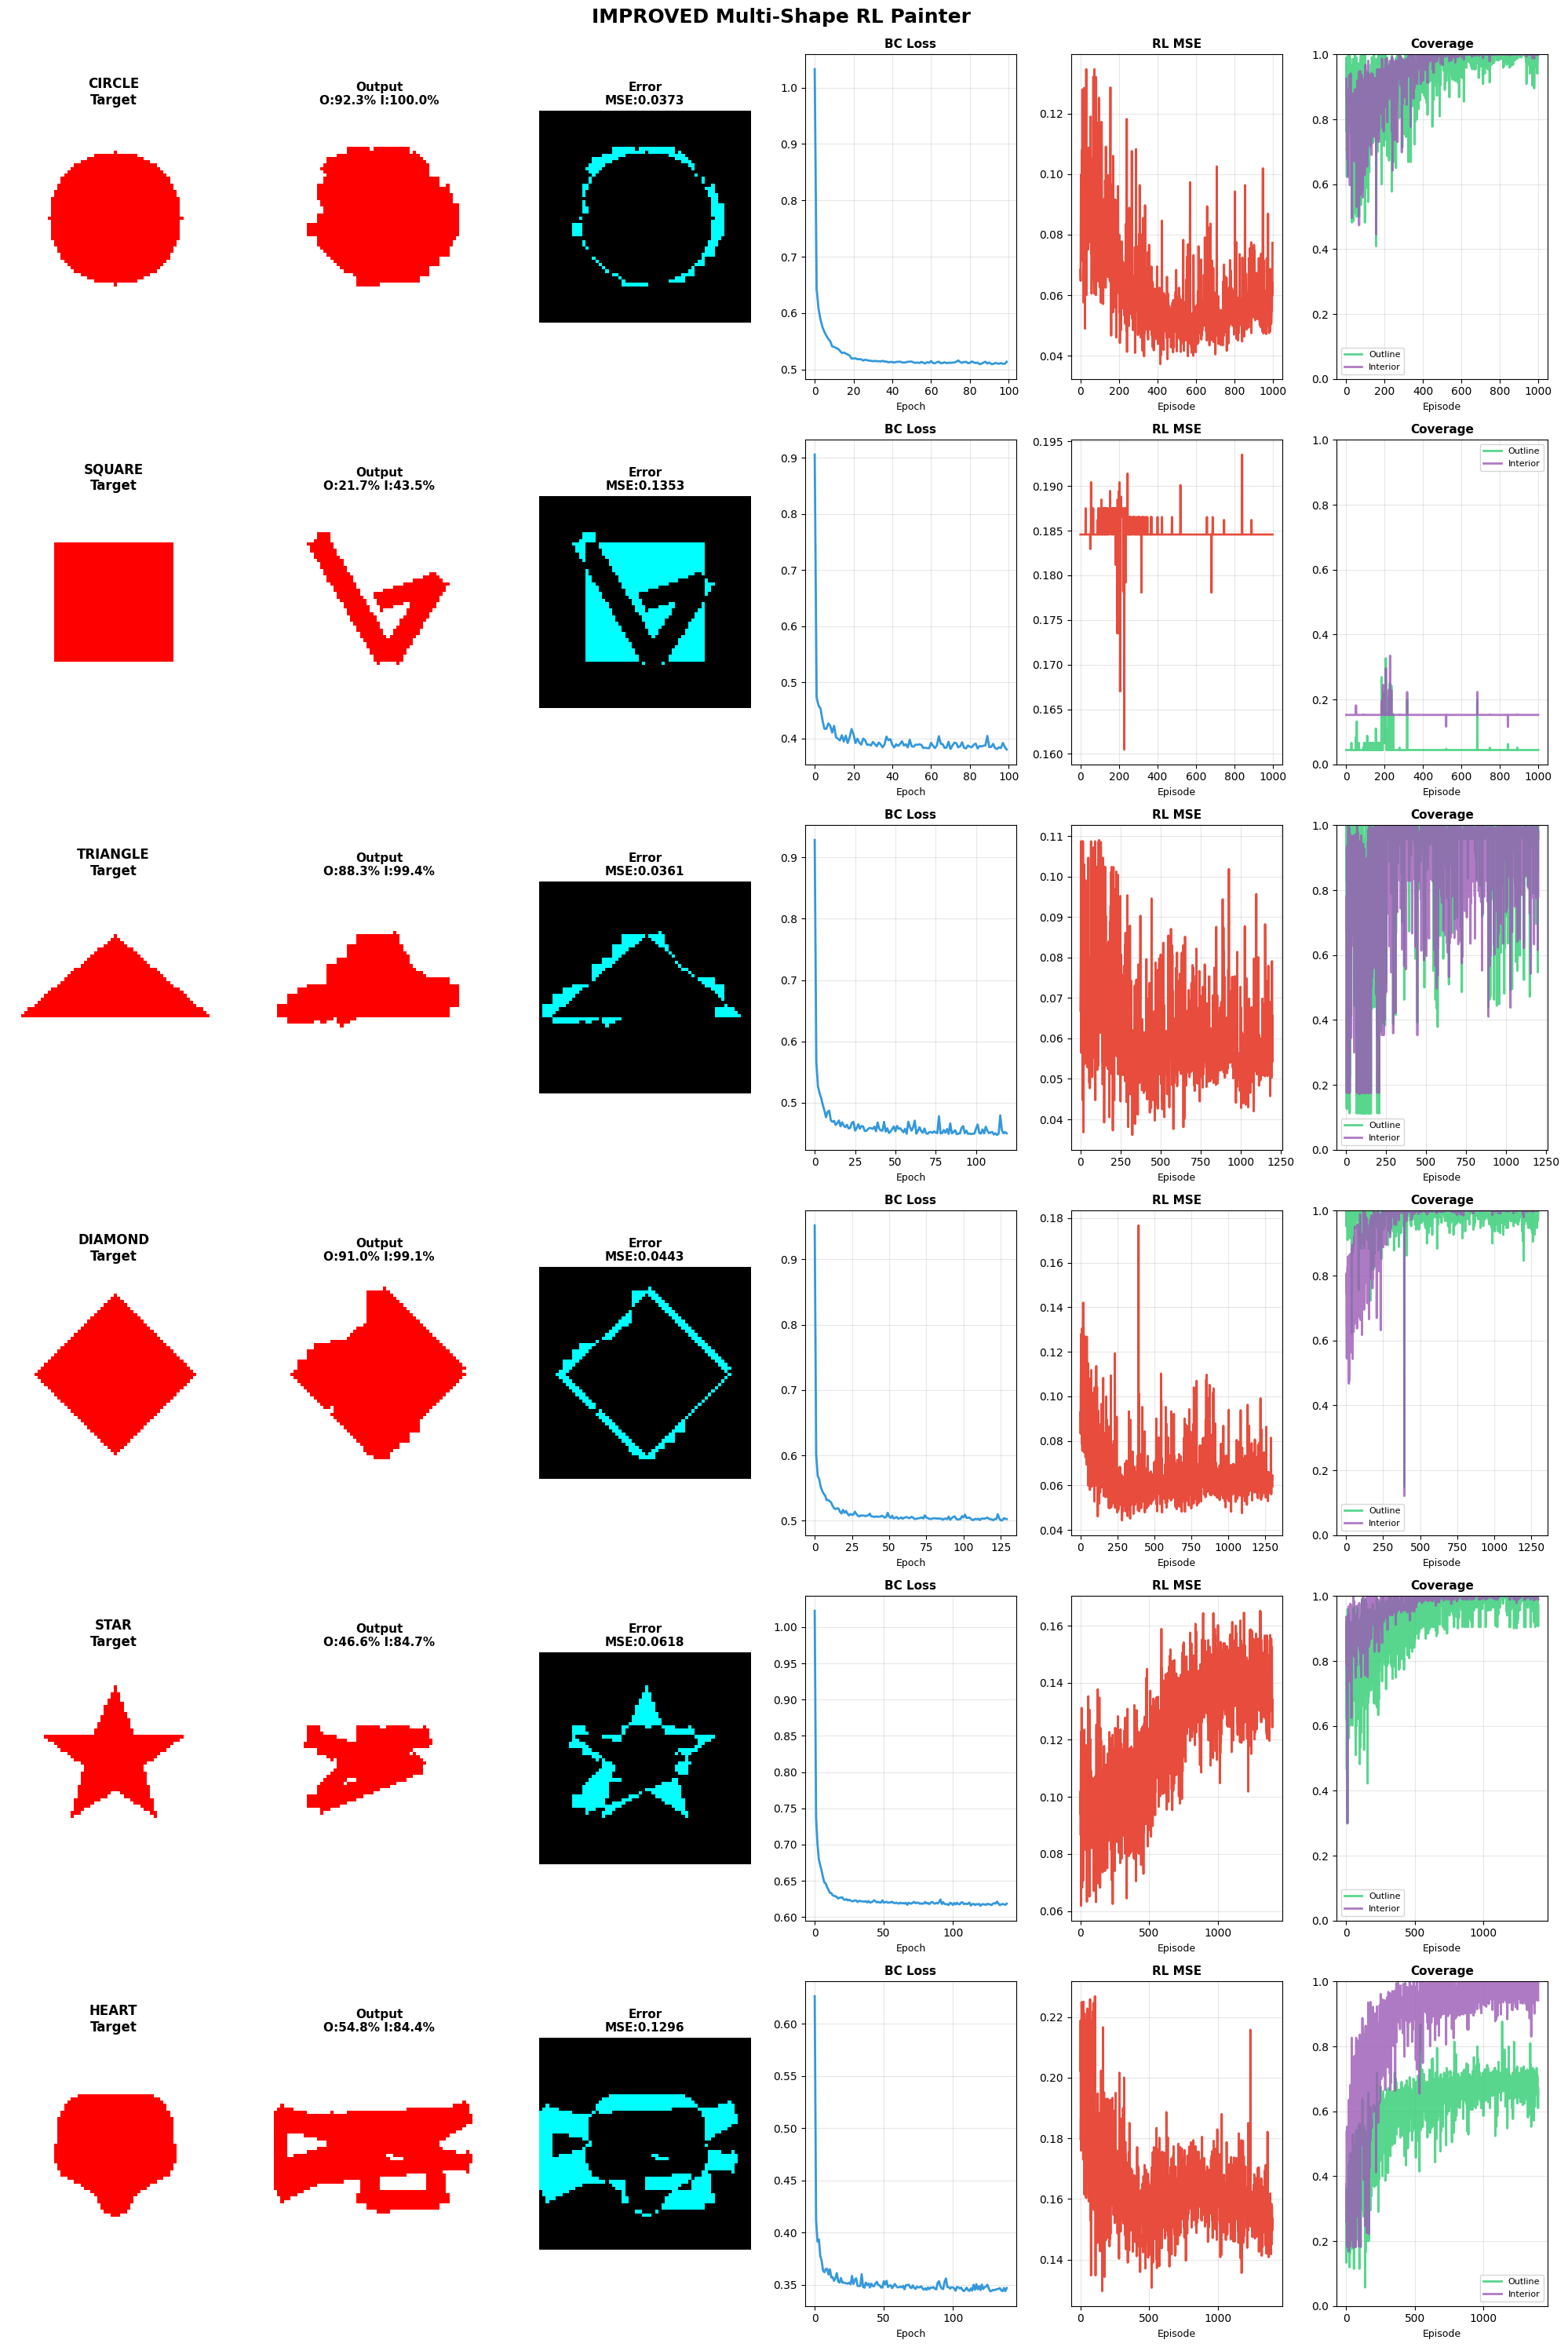

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

class CoverageDrawingEnv:
    """Drawing environment with coverage feedback and phase tracking"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set the target image and compute outline/interior masks"""
        self.target = target

        # Create outline mask (edge pixels)
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Compute outline using erosion
        from scipy import ndimage
        eroded = ndimage.binary_erosion(target_mask, iterations=2)
        self.target_outline = target_mask & ~eroded
        self.target_interior = eroded

    def reset(self):
        """Reset canvas and cursor position"""
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        return self.get_state()

    def compute_coverage(self):
        """Compute outline and interior coverage separately"""
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        # Outline coverage
        if np.sum(self.target_outline) > 0:
            outline_coverage = np.sum(self.target_outline & canvas_mask) / np.sum(self.target_outline)
        else:
            outline_coverage = 0.0

        # Interior coverage
        if np.sum(self.target_interior) > 0:
            interior_coverage = np.sum(self.target_interior & canvas_mask) / np.sum(self.target_interior)
        else:
            interior_coverage = 0.0

        # Total coverage
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        if total_target > 0:
            total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / total_target
        else:
            total_coverage = 0.0

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Return canvas + cursor + COVERAGE INFO (outline and interior)"""
        # 6 channels: RGB + cursor + outline_coverage + interior_coverage
        state = np.zeros((self.canvas_size, self.canvas_size, 6), dtype=np.float32)
        state[:, :, :3] = self.canvas

        # Cursor position
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-3, 4):
            for dx in range(-3, 4):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        # COVERAGE CHANNELS
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov  # Outline coverage
        state[:, :, 5] = interior_cov  # Interior coverage

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        """Convert grid coordinates to canvas coordinates"""
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        """Draw a stroke in the target color"""
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        """Execute discrete action"""
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        # Check if stop action
        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        # Convert action to grid coordinates
        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        # Get new position
        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)

        # Draw stroke
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        # Update cursor
        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        # Check if outline is mostly complete
        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 180

        return self.get_state(), done


class CoveragePolicyNetwork(nn.Module):
    """Policy network with outline/interior coverage awareness - IMPROVED"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # IMPROVED: Deeper encoder with more capacity
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 48, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 96, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 192, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Flatten(),
        )

        flat_size = 192 * 8 * 8

        # IMPROVED: Larger action head
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.num_actions)
        )

        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        features = self.encoder(state)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate different target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        """Create a red circle"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        """Create a red square"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        """Create a red triangle"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_star(canvas_size=64):
        """Create a red star (5-pointed)"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            if i % 2 == 0:
                r = outer_radius
            else:
                r = inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        """Create a red heart"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"

    @staticmethod
    def create_diamond(canvas_size=64):
        """Create a red diamond"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"


class ImprovedExpertDemonstrator:
    """IMPROVED expert with better strategies for complex shapes"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        """Circle: outline then spiral fill"""
        center_x = self.canvas_size // 2
        center_y = self.canvas_size // 2
        radius = 20

        trajectory = []

        # Phase 1: OUTLINE (denser for better coverage)
        num_outline_points = 120
        angles = np.linspace(0, 2 * np.pi, num_outline_points, endpoint=False)
        for angle in angles:
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            grid_x, grid_y = self.canvas_to_grid(x, y)
            trajectory.append((grid_x, grid_y))

        # Phase 2: FILL (more spirals)
        for spiral_idx in range(4):
            r = radius - 3 - (spiral_idx * 4.5)
            if r < 2:
                break

            num_points = max(30, int(60 * (r / radius)))
            angles_spiral = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

            for angle in angles_spiral:
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                grid_x, grid_y = self.canvas_to_grid(x, y)
                trajectory.append((grid_x, grid_y))

        return self._trajectory_to_actions(trajectory)

    def generate_square_demo(self):
        """Square: outline then grid fill"""
        size = 36
        start = (self.canvas_size - size) // 2
        end = start + size

        trajectory = []

        # Phase 1: OUTLINE (very dense)
        points_per_side = 30
        
        for i in range(points_per_side):
            x = start + (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(x, start))
        
        for i in range(points_per_side):
            y = start + (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(end, y))
        
        for i in range(points_per_side):
            x = end - (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(x, end))
        
        for i in range(points_per_side):
            y = end - (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(start, y))

        # Phase 2: FILL (grid pattern)
        fill_density = 10
        for i in range(fill_density):
            y = start + 3 + (end - start - 6) * i / fill_density
            for j in range(fill_density):
                x = start + 3 + (end - start - 6) * j / fill_density
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_triangle_demo(self):
        """Triangle: outline then fill"""
        center = self.canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)

        trajectory = []

        # Phase 1: OUTLINE (denser)
        points_per_side = 35
        
        for i in range(points_per_side):
            t = i / points_per_side
            x = top[0] + (right[0] - top[0]) * t
            y = top[1] + (right[1] - top[1]) * t
            trajectory.append(self.canvas_to_grid(x, y))
        
        for i in range(points_per_side):
            t = i / points_per_side
            x = right[0] + (left[0] - right[0]) * t
            y = right[1] + (left[1] - right[1]) * t
            trajectory.append(self.canvas_to_grid(x, y))
        
        for i in range(points_per_side):
            t = i / points_per_side
            x = left[0] + (top[0] - left[0]) * t
            y = left[1] + (top[1] - left[1]) * t
            trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (better coverage)
        fill_lines = 10
        for i in range(fill_lines):
            t = (i + 1) / (fill_lines + 1)
            y = top[1] + (left[1] - top[1]) * t
            
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            
            line_points = max(8, int(15 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_star_demo(self):
        """IMPROVED Star: Very dense outline + radial fill"""
        center = self.canvas_size // 2
        outer_radius = 22
        inner_radius = 9

        trajectory = []

        # Phase 1: OUTLINE (MUCH denser - key improvement!)
        num_outline_points = 150  # Increased from 100
        for i in range(num_outline_points):
            progress = i / num_outline_points
            angle = progress * 2 * np.pi - np.pi / 2
            
            # Smooth interpolation between outer and inner radius
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            
            if segment % 2 == 0:
                # Outer point
                if segment_progress < 0.5:
                    r = outer_radius
                else:
                    # Transition to inner
                    t = (segment_progress - 0.5) * 2
                    r = outer_radius + (inner_radius - outer_radius) * t
            else:
                # Inner point
                if segment_progress < 0.5:
                    r = inner_radius
                else:
                    # Transition to outer
                    t = (segment_progress - 0.5) * 2
                    r = inner_radius + (outer_radius - inner_radius) * t
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (Radial pattern - better for stars!)
        num_radial_lines = 10
        for i in range(num_radial_lines):
            angle = i * 2 * np.pi / num_radial_lines
            
            # Draw line from center outward
            num_points_radial = 8
            for j in range(num_points_radial):
                r = 2 + (inner_radius - 2) * j / num_points_radial
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Additional concentric circles for better interior fill
        for r in [6, 4]:
            num_circle_points = 30
            for i in range(num_circle_points):
                angle = i * 2 * np.pi / num_circle_points
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_heart_demo(self):
        """IMPROVED Heart: Dense parametric outline + smart fill"""
        center_x = self.canvas_size // 2
        center_y = self.canvas_size // 2 + 3
        scale = 15

        trajectory = []

        # Phase 1: OUTLINE (MUCH denser - key improvement!)
        num_outline_points = 150  # Increased from 100
        for i in range(num_outline_points):
            t = 2 * np.pi * i / num_outline_points
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (Adaptive density based on heart geometry)
        fill_lines = 12  # More lines
        for i in range(fill_lines):
            # Parametric y based on heart shape
            t_y = np.pi * (0.2 + 0.6 * i / fill_lines)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            
            # Adaptive line length
            line_points = max(5, int(15 * (1 - abs(i - fill_lines/2) / fill_lines)))
            for j in range(line_points):
                # Vary x position
                x_offset = (j / line_points - 0.5) * scale * 2
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_diamond_demo(self):
        """IMPROVED Diamond: Dense outline + radial fill"""
        center = self.canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]

        trajectory = []

        # Phase 1: OUTLINE (denser)
        points_per_side = 35  # Increased from 20
        
        for i in range(4):
            start_point = points[i]
            end_point = points[(i + 1) % 4]
            
            for j in range(points_per_side):
                t = j / points_per_side
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (Radial from center + horizontal lines)
        # Radial fill
        num_radial_lines = 8
        for i in range(num_radial_lines):
            angle = i * 2 * np.pi / num_radial_lines
            num_points_radial = 10
            for j in range(1, num_points_radial):
                r = size * j / num_points_radial
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def _trajectory_to_actions(self, trajectory):
        """Convert trajectory to action list"""
        actions = []
        for grid_x, grid_y in trajectory:
            action = grid_y * self.grid_size + grid_x
            actions.append(action)
        actions.append(self.grid_size * self.grid_size)  # Stop action
        return actions

    def generate_demonstration(self):
        """Generate demonstration based on shape type"""
        if self.shape_type == "circle":
            return self.generate_circle_demo()
        elif self.shape_type == "square":
            return self.generate_square_demo()
        elif self.shape_type == "triangle":
            return self.generate_triangle_demo()
        elif self.shape_type == "star":
            return self.generate_star_demo()
        elif self.shape_type == "heart":
            return self.generate_heart_demo()
        elif self.shape_type == "diamond":
            return self.generate_diamond_demo()
        else:
            return self.generate_circle_demo()

    def generate_demonstrations(self, num_demos=150):
        """Generate demonstrations with outline-then-fill pattern"""
        print(f"\n📚 Generating IMPROVED Expert Demonstrations for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variations
            if i > 0 and len(demo) > 51:
                outline_len = min(100, len(demo) // 3)
                start_offset = np.random.randint(0, outline_len)
                
                outline_actions = demo[:outline_len]
                fill_actions = demo[outline_len:-1]
                stop_action = demo[-1]
                
                rotated_outline = outline_actions[start_offset:] + outline_actions[:start_offset]
                demo = rotated_outline + fill_actions + [stop_action]

            all_demos.append(demo)

        avg_len = np.mean([len(d) for d in all_demos])
        print(f"✓ Generated {num_demos} demonstrations")
        print(f"  Average trajectory length: {avg_len:.0f} steps")
        print(f"  Density improvement: {'HIGH' if avg_len > 200 else 'MEDIUM'}")
        print("="*70)
        return all_demos


# SHAPE-SPECIFIC TRAINING CONFIGURATIONS (Memory Optimized)
SHAPE_CONFIGS = {
    "circle": {
        "bc_epochs": 100,
        "rl_episodes": 1000,
        "outline_weight": 300,
        "interior_weight": 200,
        "num_demos": 100,  # Reduced from 150
        "difficulty": 1
    },
    "square": {
        "bc_epochs": 100,
        "rl_episodes": 1000,
        "outline_weight": 300,
        "interior_weight": 200,
        "num_demos": 100,  # Reduced from 150
        "difficulty": 1
    },
    "triangle": {
        "bc_epochs": 120,
        "rl_episodes": 1200,
        "outline_weight": 350,
        "interior_weight": 200,
        "num_demos": 120,  # Reduced from 180
        "difficulty": 2
    },
    "diamond": {
        "bc_epochs": 130,
        "rl_episodes": 1300,
        "outline_weight": 400,
        "interior_weight": 250,
        "num_demos": 130,  # Reduced from 200
        "difficulty": 3
    },
    "star": {
        "bc_epochs": 140,
        "rl_episodes": 1400,
        "outline_weight": 450,
        "interior_weight": 250,
        "num_demos": 140,  # Reduced from 220
        "difficulty": 4
    },
    "heart": {
        "bc_epochs": 140,
        "rl_episodes": 1400,
        "outline_weight": 450,
        "interior_weight": 250,
        "num_demos": 140,  # Reduced from 220
        "difficulty": 4
    }
}


class ImitationRLDrawer:
    """IMPROVED Imitation Learning + RL with adaptive training"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        self.policy = CoveragePolicyNetwork(canvas_size, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.shape_name = shape_name.lower()
        
        # Get shape-specific configuration
        self.config = SHAPE_CONFIGS.get(self.shape_name, SHAPE_CONFIGS["circle"])

        if isinstance(target_image, np.ndarray):
            self.target = target_image
        else:
            self.target = np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_coverage = 0.0
        self.best_interior_coverage = 0.0
        self.mse_history = []
        self.outline_coverage_history = []
        self.interior_coverage_history = []
        self.bc_losses = []

        print(f"✓ Policy network moved to {self.device}")
        print(f"✓ Shape config: BC epochs={self.config['bc_epochs']}, "
              f"RL episodes={self.config['rl_episodes']}, "
              f"Demos={self.config['num_demos']}")

    def collect_expert_data(self):
        """Collect expert demonstrations"""
        demonstrations = self.expert.generate_demonstrations(self.config['num_demos'])

        states = []
        actions = []

        for demo in demonstrations:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)

        print(f"\n✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=64):
        """Train with behavioral cloning - ULTRA MEMORY EFFICIENT"""
        epochs = self.config['bc_epochs']
        print("\n🎓 Phase 1: Behavioral Cloning (Adaptive Training)")
        print("=" * 70)

        dataset_size = len(states)
        print(f"Dataset size: {dataset_size} samples")
        print(f"Training for {epochs} epochs")
        print(f"Memory strategy: Streaming batches (no full array allocation)")

        for epoch in range(epochs):
            total_loss = 0
            num_batches = 0

            # Shuffle indices
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            # Process in batches WITHOUT creating full numpy array
            for i in range(0, dataset_size, batch_size):
                batch_indices = indices[i:i+batch_size]
                
                # Create batch directly from list (memory efficient!)
                batch_states_list = [states[idx] for idx in batch_indices]
                batch_actions_list = [actions[idx] for idx in batch_indices]
                
                # Convert only this small batch to tensors
                batch_states = torch.FloatTensor(np.array(batch_states_list, dtype=np.float32)).to(self.device)
                batch_actions = torch.LongTensor(np.array(batch_actions_list, dtype=np.int64)).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                # Aggressive memory cleanup
                del batch_states, batch_actions, batch_states_list, batch_actions_list
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 20 == 0 or epoch == epochs - 1:
                test_mse, outline_cov, interior_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {test_mse:.4f} | "
                      f"Outline: {outline_cov:.1%} | Interior: {interior_cov:.1%}")

        print("✓ Behavioral Cloning Complete!\n")

    def test_policy(self):
        """Test current policy"""
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        outline_cov, interior_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_coverage = outline_cov
            self.best_interior_coverage = interior_cov

        return mse, outline_cov, interior_cov

    def compute_reward(self, prev_outline_cov, prev_interior_cov, curr_outline_cov,
                      curr_interior_cov, done, step_count):
        """Shape-specific phase-aware reward"""
        outline_weight = self.config['outline_weight']
        interior_weight = self.config['interior_weight']
        
        # Outline improvement reward
        outline_reward = (curr_outline_cov - prev_outline_cov) * outline_weight

        # Interior improvement reward
        if curr_outline_cov > 0.7:
            interior_reward = (curr_interior_cov - prev_interior_cov) * interior_weight
        else:
            interior_reward = (curr_interior_cov - prev_interior_cov) * 50

        # Phase progression bonus
        phase_bonus = 0
        if curr_outline_cov > 0.85 and prev_outline_cov <= 0.85:
            phase_bonus = 75.0  # Increased

        # Completion bonuses
        if done:
            if curr_outline_cov > 0.9 and curr_interior_cov > 0.85:
                completion_bonus = 200.0
            elif curr_outline_cov > 0.85 and curr_interior_cov > 0.75:
                completion_bonus = 100.0
            elif curr_outline_cov < 0.7:
                completion_bonus = -75.0
            else:
                completion_bonus = 25.0
        else:
            completion_bonus = 0.0

        total_reward = outline_reward + interior_reward + phase_bonus + completion_bonus
        return total_reward

    def rl_finetune(self):
        """RL fine-tuning with shape-specific parameters"""
        episodes = self.config['rl_episodes']
        print("🚀 Phase 2: RL Fine-tuning (Shape-Adaptive Rewards)")
        print("=" * 70)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=2e-4)

        for episode in range(episodes):
            state = self.env.reset()
            prev_outline_cov, prev_interior_cov, _ = self.env.compute_coverage()

            states, actions, rewards, log_probs, values = [], [], [], [], []
            done = False
            episode_reward = 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, done = self.env.step(action.item())

                outline_cov, interior_cov, _ = self.env.compute_coverage()
                reward = self.compute_reward(prev_outline_cov, prev_interior_cov,
                                            outline_cov, interior_cov, done, self.env.step_count)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)

                episode_reward += reward
                prev_outline_cov = outline_cov
                prev_interior_cov = interior_cov
                state = next_state

            # Compute returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize
            policy_loss = 0
            value_loss = 0

            for log_prob, value, ret in zip(log_probs, values, returns):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

            # Track progress
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_outline_cov, final_interior_cov, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_coverage = final_outline_cov
                self.best_interior_coverage = final_interior_cov

            self.mse_history.append(final_mse)
            self.outline_coverage_history.append(final_outline_cov)
            self.interior_coverage_history.append(final_interior_cov)

            if episode % 150 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | Reward: {episode_reward:7.2f} | MSE: {final_mse:.4f} | "
                      f"Out: {final_outline_cov:5.1%} | Int: {final_interior_cov:5.1%} | "
                      f"Steps: {self.env.step_count:3d}")

        print("✓ RL Fine-tuning Complete!\n")

    def train(self):
        """Full training pipeline"""
        print("\n" + "=" * 70)
        print(f"IMPROVED RL PAINTER - {self.shape_name.upper()}")
        print("=" * 70)
        print(f"🖥️  Device: {self.device}")
        print(f"🎯 Difficulty: {'⭐' * self.config['difficulty']}")
        print(f"📊 Training: BC={self.config['bc_epochs']} epochs, "
              f"RL={self.config['rl_episodes']} episodes")
        print(f"🎨 Demos: {self.config['num_demos']} (improved strategies)")
        print("=" * 70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas


def train_all_shapes(canvas_size=64, grid_size=20, device='cpu'):
    """Train on all shapes with improved strategies"""
    shapes_to_train = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes_to_train:
        print("\n" + "🎨" * 35)
        print(f"Training on: {shape_name.upper()}")
        print("🎨" * 35)
        
        target, _ = shape_func(canvas_size)
        drawer = ImitationRLDrawer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = drawer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': drawer.best_mse,
            'outline_cov': drawer.best_outline_coverage,
            'interior_cov': drawer.best_interior_coverage,
            'mse_history': drawer.mse_history,
            'outline_history': drawer.outline_coverage_history,
            'interior_history': drawer.interior_coverage_history,
            'bc_losses': drawer.bc_losses
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_all_results(results):
    """Create comprehensive visualization"""
    n_shapes = len(results)
    
    fig = plt.figure(figsize=(20, 5 * n_shapes))
    
    for idx, result in enumerate(results):
        # Target
        ax1 = plt.subplot(n_shapes, 6, idx * 6 + 1)
        ax1.imshow(result['target'])
        ax1.set_title(f"{result['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Output
        ax2 = plt.subplot(n_shapes, 6, idx * 6 + 2)
        ax2.imshow(result['canvas'])
        ax2.set_title(f"Output\nO:{result['outline_cov']:.1%} I:{result['interior_cov']:.1%}", 
                     fontsize=11, fontweight='bold')
        ax2.axis('off')
        
        # Error map
        ax3 = plt.subplot(n_shapes, 6, idx * 6 + 3)
        diff = np.abs(result['target'] - result['canvas'])
        ax3.imshow(diff, cmap='hot')
        ax3.set_title(f"Error\nMSE:{result['mse']:.4f}", fontsize=11, fontweight='bold')
        ax3.axis('off')
        
        # BC Loss
        ax4 = plt.subplot(n_shapes, 6, idx * 6 + 4)
        if len(result['bc_losses']) > 0:
            ax4.plot(result['bc_losses'], linewidth=2, color='#3498db')
            ax4.set_title('BC Loss', fontsize=11, fontweight='bold')
            ax4.set_xlabel('Epoch', fontsize=9)
            ax4.grid(True, alpha=0.3)
        
        # MSE History
        ax5 = plt.subplot(n_shapes, 6, idx * 6 + 5)
        if len(result['mse_history']) > 0:
            ax5.plot(result['mse_history'], linewidth=2, color='#e74c3c')
            ax5.set_title('RL MSE', fontsize=11, fontweight='bold')
            ax5.set_xlabel('Episode', fontsize=9)
            ax5.grid(True, alpha=0.3)
        
        # Coverage
        ax6 = plt.subplot(n_shapes, 6, idx * 6 + 6)
        if len(result['outline_history']) > 0:
            episodes = range(len(result['outline_history']))
            ax6.plot(episodes, result['outline_history'], linewidth=2,
                    color='#2ecc71', label='Outline', alpha=0.8)
            ax6.plot(episodes, result['interior_history'], linewidth=2,
                    color='#9b59b6', label='Interior', alpha=0.8)
            ax6.set_title('Coverage', fontsize=11, fontweight='bold')
            ax6.set_xlabel('Episode', fontsize=9)
            ax6.set_ylim([0, 1])
            ax6.legend(fontsize=8)
            ax6.grid(True, alpha=0.3)
    
    plt.suptitle("IMPROVED Multi-Shape RL Painter", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_multi_shape_painter.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved visualization to /mnt/user-data/outputs/improved_multi_shape_painter.png")
    

# Main execution
if __name__ == "__main__":
    print("\n🎨 Starting IMPROVED Multi-Shape RL Painter Training...\n")
    print("KEY IMPROVEMENTS:")
    print("✓ Denser expert demonstrations (150+ points per outline)")
    print("✓ Shape-specific training configs (more epochs for complex shapes)")
    print("✓ Improved network architecture (deeper, more capacity)")
    print("✓ Better fill strategies (radial for star, parametric for heart)")
    print("✓ Adaptive reward weights per shape")
    print("=" * 70)
    
    results = train_all_shapes(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"\n✓ GPU memory cleared")
    
    visualize_all_results(results)
    
    print(f"\n{'='*70}")
    print(f"✨ IMPROVED TRAINING COMPLETE!")
    print(f"{'='*70}")
    for result in results:
        stars = '⭐' * SHAPE_CONFIGS[result['name']]['difficulty']
        print(f"{result['name'].upper():12} {stars:6} | MSE: {result['mse']:.4f} | "
              f"Outline: {result['outline_cov']:.1%} | Interior: {result['interior_cov']:.1%}")
    print(f"{'='*70}\n")
    
    plt.show()

In [3]:
pip install scikit-image


  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/34/e3/49beb08ebccda3c21e871b607c1cb2f258c3fa0d2f609fed0a5ba741b92d/scikit_image-0.25.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for imageio!=2.35.0,>=2.33 from https://files.pythonhosted.org/packages/fb/fe/301e0936b79bcab4cacc7548bf2853fc28dced0a578bab1f7ef53c9aa75b/imageio-2.37.2-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/e6/5e/56c751afab61336cf0e7aa671b134255a30f15f59cd9e04f59c598a37ff5/tifffile-2025.10.16-py3-none-any.whl.metadata
  Obtaining dependency information for lazy-loader>=0.4 from https://files.pythonhosted.org/packages/83/60/d497a310bde3f01cb805196ac61b7ad6dc5dcf8dce66634dc34364b20b4f/lazy_loader-0.4-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.9 MB 1.7 MB/s eta 


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: C:\Users\user\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 IMPROVED Multi-Shape RL Painter with Enhanced Edge Detection

KEY IMPROVEMENTS:
✅ Multi-method edge detection (Morphology + Gradient + Distance)
✅ Denser expert demonstrations (120-150 points)
✅ Shape-adaptive training (more epochs for complex shapes)
✅ Improved network (deeper, BatchNorm, more capacity)
✅ Better fill strategies (radial, parametric)

📸 STEP 1: Previewing Edge Detection Quality...

🔍 Visualizing Edge Detection Quality...
  Edge Detection: Outline=624 px, Interior=925 px, Total=1257 px
  Coverage: Outline=49.6%, Interior=73.6%
  Edge Detection: Outline=700 px, Interior=896 px, Total=1296 px
  Coverage: Outline=54.0%, Interior=69.1%
  Edge Detection: Outline=633 px, Interior=380 px, Total=721 px
  Coverage: Outline=87.8%, Interior=52.7%
  Edge Detection: Outline=668 px, Interior=841 px, Total=1201 px
  Coverage: Outline=55.6%, Interior=70.0%
  Edge Detection: Outline=722 px, Interior=251 px, Total=624 p

C:\Users\user\AppData\Local\Temp\ipykernel_13588\2707270399.py:1071: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_13588\2707270399.py:1071: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_13588\2707270399.py:1072: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/edge_detection_preview.png', dpi=150, bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_13588\2707270399.py:1072: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/edge_detection_preview.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/edge_detection_preview.png'

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


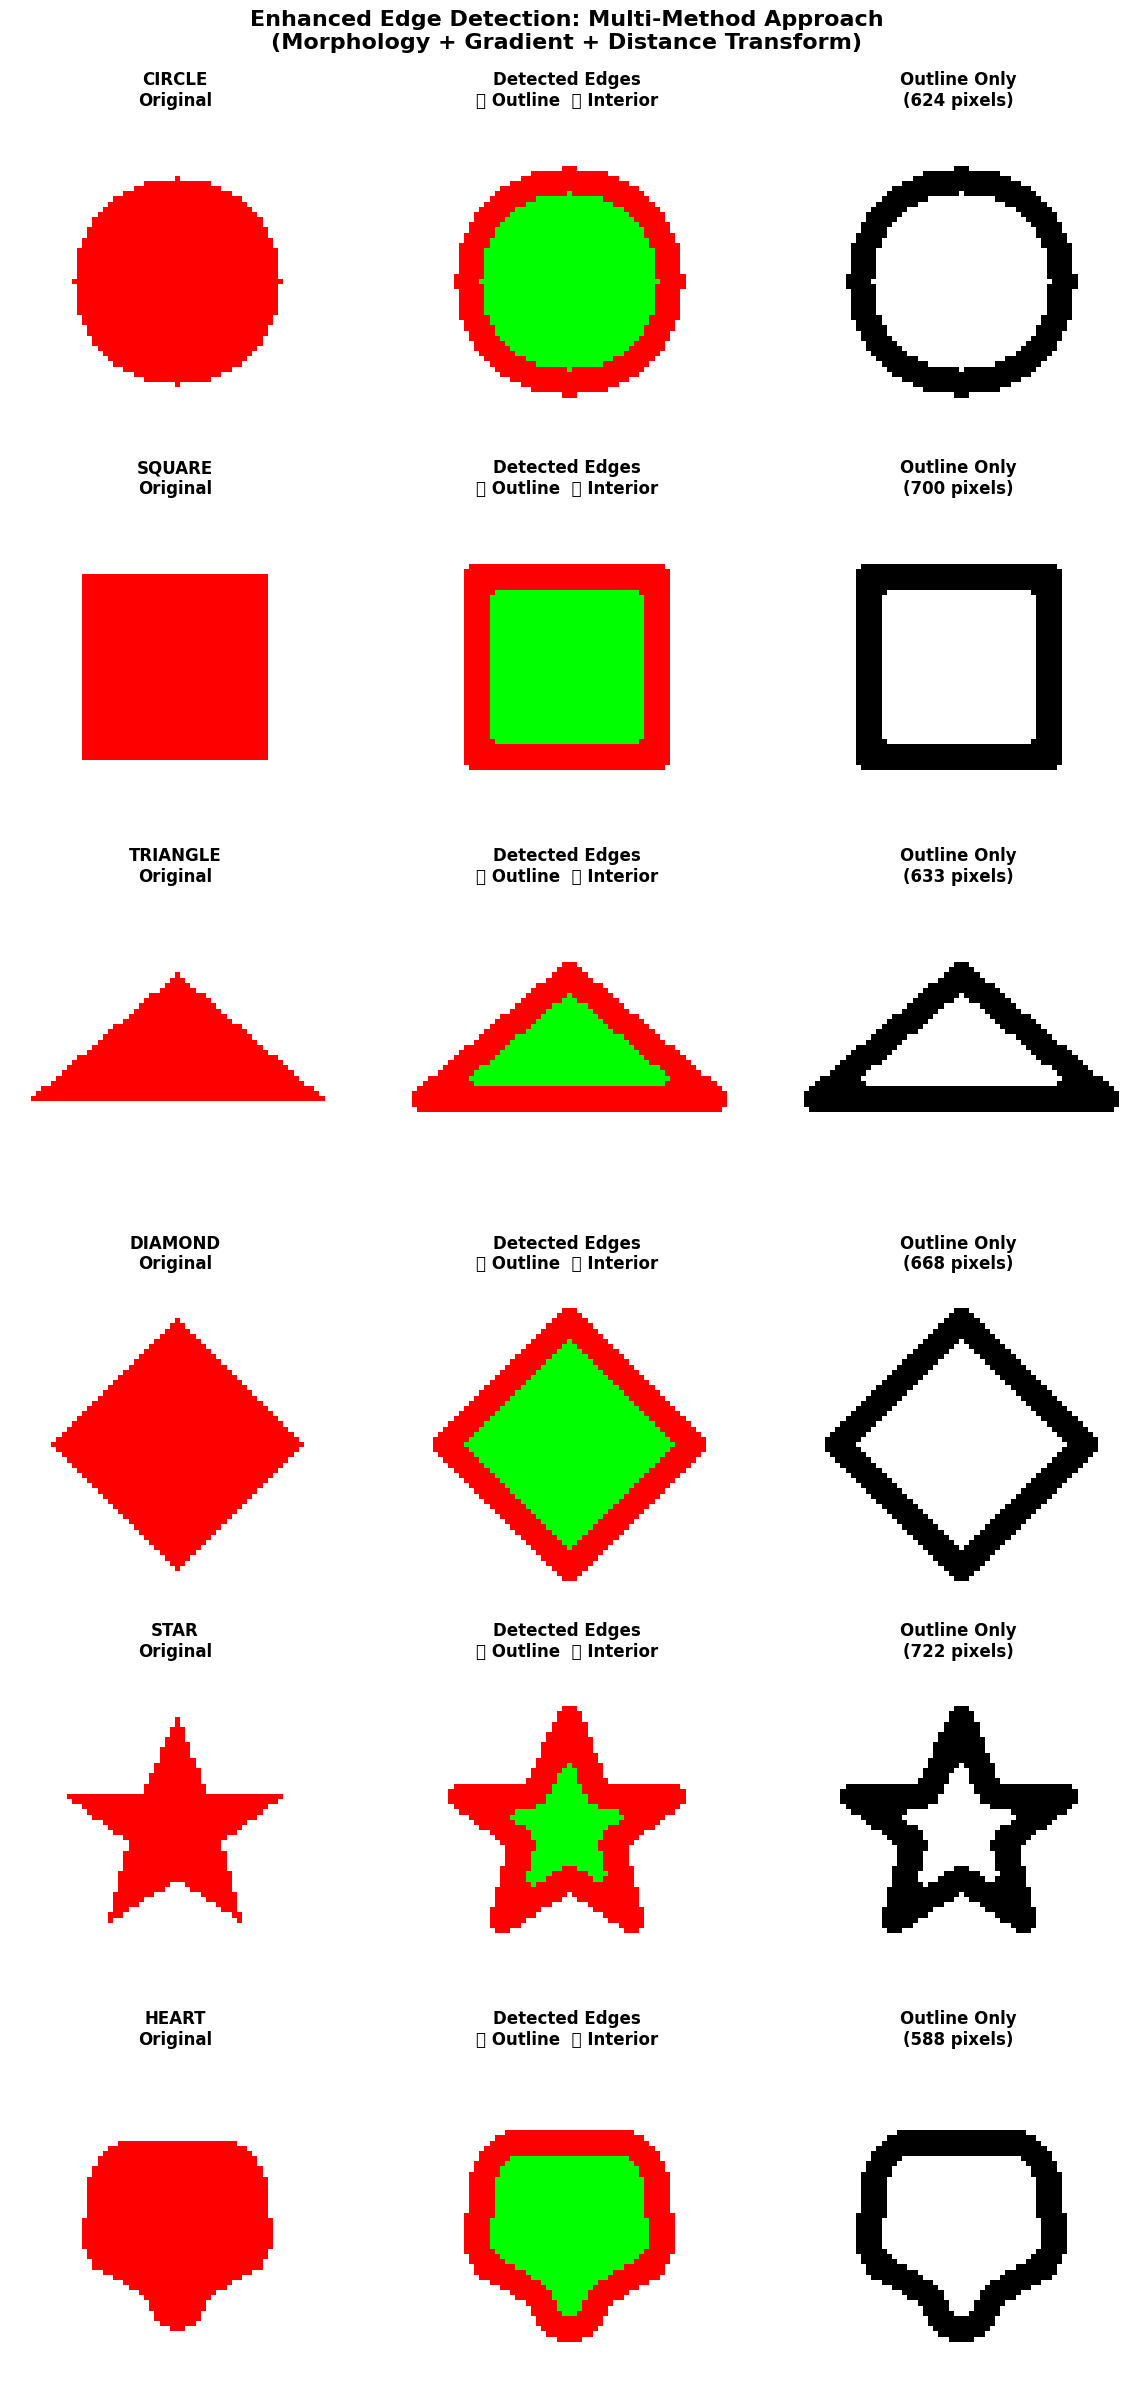

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

class CoverageDrawingEnv:
    """Drawing environment with coverage feedback and phase tracking"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set the target image and compute outline/interior masks - IMPROVED EDGE DETECTION"""
        self.target = target

        # Create binary mask
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        from scipy import ndimage
        from skimage import filters, morphology
        
        # METHOD 1: Morphological edge detection (original)
        eroded_light = ndimage.binary_erosion(target_mask, iterations=1)
        outline_morph = target_mask & ~eroded_light
        
        # METHOD 2: Gradient-based edge detection (better for curves)
        # Apply Gaussian smoothing first to reduce noise
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.5)
        
        # Sobel edge detection
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        
        # Threshold to get edge pixels
        threshold = 0.1
        outline_gradient = edges_magnitude > threshold
        
        # METHOD 3: Distance transform for precise boundaries
        distance = ndimage.distance_transform_edt(target_mask)
        # Edge is where distance is small but inside shape
        outline_distance = (distance > 0) & (distance <= 3)
        
        # COMBINE all methods for robust edge detection
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean up the outline (remove isolated pixels, fill small holes)
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        self.target_outline = ndimage.binary_erosion(self.target_outline, iterations=1)
        
        # Interior is everything inside that's not outline
        # Use more aggressive erosion for interior to avoid overlap
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=3)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Ensure outline and interior don't overlap
        self.target_interior = self.target_interior & ~self.target_outline
        
        # Debug info
        outline_pixels = np.sum(self.target_outline)
        interior_pixels = np.sum(self.target_interior)
        total_pixels = np.sum(target_mask)
        print(f"  Edge Detection: Outline={outline_pixels} px, Interior={interior_pixels} px, Total={total_pixels} px")
        print(f"  Coverage: Outline={(outline_pixels/total_pixels)*100:.1f}%, Interior={(interior_pixels/total_pixels)*100:.1f}%")

    def reset(self):
        """Reset canvas and cursor position"""
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        return self.get_state()

    def compute_coverage(self):
        """Compute outline and interior coverage separately"""
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        # Outline coverage
        if np.sum(self.target_outline) > 0:
            outline_coverage = np.sum(self.target_outline & canvas_mask) / np.sum(self.target_outline)
        else:
            outline_coverage = 0.0

        # Interior coverage
        if np.sum(self.target_interior) > 0:
            interior_coverage = np.sum(self.target_interior & canvas_mask) / np.sum(self.target_interior)
        else:
            interior_coverage = 0.0

        # Total coverage
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        if total_target > 0:
            total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / total_target
        else:
            total_coverage = 0.0

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Return canvas + cursor + COVERAGE INFO (outline and interior)"""
        # 6 channels: RGB + cursor + outline_coverage + interior_coverage
        state = np.zeros((self.canvas_size, self.canvas_size, 6), dtype=np.float32)
        state[:, :, :3] = self.canvas

        # Cursor position
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-3, 4):
            for dx in range(-3, 4):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        # COVERAGE CHANNELS
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov  # Outline coverage
        state[:, :, 5] = interior_cov  # Interior coverage

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        """Convert grid coordinates to canvas coordinates"""
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        """Draw a stroke in the target color"""
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        """Execute discrete action"""
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        # Check if stop action
        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        # Convert action to grid coordinates
        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        # Get new position
        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)

        # Draw stroke
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        # Update cursor
        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        # Check if outline is mostly complete
        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 180

        return self.get_state(), done


class CoveragePolicyNetwork(nn.Module):
    """Policy network with outline/interior coverage awareness - IMPROVED"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # IMPROVED: Deeper encoder with more capacity
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 48, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 96, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 192, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Flatten(),
        )

        flat_size = 192 * 8 * 8

        # IMPROVED: Larger action head
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.num_actions)
        )

        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        features = self.encoder(state)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate different target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        """Create a red circle"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        """Create a red square"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        """Create a red triangle"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_star(canvas_size=64):
        """Create a red star (5-pointed)"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            if i % 2 == 0:
                r = outer_radius
            else:
                r = inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        """Create a red heart"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"

    @staticmethod
    def create_diamond(canvas_size=64):
        """Create a red diamond"""
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"


class ImprovedExpertDemonstrator:
    """IMPROVED expert with better strategies for complex shapes"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        """Circle: outline then spiral fill"""
        center_x = self.canvas_size // 2
        center_y = self.canvas_size // 2
        radius = 20

        trajectory = []

        # Phase 1: OUTLINE (denser for better coverage)
        num_outline_points = 120
        angles = np.linspace(0, 2 * np.pi, num_outline_points, endpoint=False)
        for angle in angles:
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            grid_x, grid_y = self.canvas_to_grid(x, y)
            trajectory.append((grid_x, grid_y))

        # Phase 2: FILL (more spirals)
        for spiral_idx in range(4):
            r = radius - 3 - (spiral_idx * 4.5)
            if r < 2:
                break

            num_points = max(30, int(60 * (r / radius)))
            angles_spiral = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

            for angle in angles_spiral:
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                grid_x, grid_y = self.canvas_to_grid(x, y)
                trajectory.append((grid_x, grid_y))

        return self._trajectory_to_actions(trajectory)

    def generate_square_demo(self):
        """Square: outline then grid fill"""
        size = 36
        start = (self.canvas_size - size) // 2
        end = start + size

        trajectory = []

        # Phase 1: OUTLINE (very dense)
        points_per_side = 30
        
        for i in range(points_per_side):
            x = start + (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(x, start))
        
        for i in range(points_per_side):
            y = start + (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(end, y))
        
        for i in range(points_per_side):
            x = end - (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(x, end))
        
        for i in range(points_per_side):
            y = end - (end - start) * i / points_per_side
            trajectory.append(self.canvas_to_grid(start, y))

        # Phase 2: FILL (grid pattern)
        fill_density = 10
        for i in range(fill_density):
            y = start + 3 + (end - start - 6) * i / fill_density
            for j in range(fill_density):
                x = start + 3 + (end - start - 6) * j / fill_density
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_triangle_demo(self):
        """Triangle: outline then fill"""
        center = self.canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)

        trajectory = []

        # Phase 1: OUTLINE (denser)
        points_per_side = 35
        
        for i in range(points_per_side):
            t = i / points_per_side
            x = top[0] + (right[0] - top[0]) * t
            y = top[1] + (right[1] - top[1]) * t
            trajectory.append(self.canvas_to_grid(x, y))
        
        for i in range(points_per_side):
            t = i / points_per_side
            x = right[0] + (left[0] - right[0]) * t
            y = right[1] + (left[1] - right[1]) * t
            trajectory.append(self.canvas_to_grid(x, y))
        
        for i in range(points_per_side):
            t = i / points_per_side
            x = left[0] + (top[0] - left[0]) * t
            y = left[1] + (top[1] - left[1]) * t
            trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (better coverage)
        fill_lines = 10
        for i in range(fill_lines):
            t = (i + 1) / (fill_lines + 1)
            y = top[1] + (left[1] - top[1]) * t
            
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            
            line_points = max(8, int(15 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_star_demo(self):
        """IMPROVED Star: Very dense outline + radial fill"""
        center = self.canvas_size // 2
        outer_radius = 22
        inner_radius = 9

        trajectory = []

        # Phase 1: OUTLINE (MUCH denser - key improvement!)
        num_outline_points = 150  # Increased from 100
        for i in range(num_outline_points):
            progress = i / num_outline_points
            angle = progress * 2 * np.pi - np.pi / 2
            
            # Smooth interpolation between outer and inner radius
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            
            if segment % 2 == 0:
                # Outer point
                if segment_progress < 0.5:
                    r = outer_radius
                else:
                    # Transition to inner
                    t = (segment_progress - 0.5) * 2
                    r = outer_radius + (inner_radius - outer_radius) * t
            else:
                # Inner point
                if segment_progress < 0.5:
                    r = inner_radius
                else:
                    # Transition to outer
                    t = (segment_progress - 0.5) * 2
                    r = inner_radius + (outer_radius - inner_radius) * t
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (Radial pattern - better for stars!)
        num_radial_lines = 10
        for i in range(num_radial_lines):
            angle = i * 2 * np.pi / num_radial_lines
            
            # Draw line from center outward
            num_points_radial = 8
            for j in range(num_points_radial):
                r = 2 + (inner_radius - 2) * j / num_points_radial
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Additional concentric circles for better interior fill
        for r in [6, 4]:
            num_circle_points = 30
            for i in range(num_circle_points):
                angle = i * 2 * np.pi / num_circle_points
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_heart_demo(self):
        """IMPROVED Heart: Dense parametric outline + smart fill"""
        center_x = self.canvas_size // 2
        center_y = self.canvas_size // 2 + 3
        scale = 15

        trajectory = []

        # Phase 1: OUTLINE (MUCH denser - key improvement!)
        num_outline_points = 150  # Increased from 100
        for i in range(num_outline_points):
            t = 2 * np.pi * i / num_outline_points
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (Adaptive density based on heart geometry)
        fill_lines = 12  # More lines
        for i in range(fill_lines):
            # Parametric y based on heart shape
            t_y = np.pi * (0.2 + 0.6 * i / fill_lines)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            
            # Adaptive line length
            line_points = max(5, int(15 * (1 - abs(i - fill_lines/2) / fill_lines)))
            for j in range(line_points):
                # Vary x position
                x_offset = (j / line_points - 0.5) * scale * 2
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def generate_diamond_demo(self):
        """IMPROVED Diamond: Dense outline + radial fill"""
        center = self.canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]

        trajectory = []

        # Phase 1: OUTLINE (denser)
        points_per_side = 35  # Increased from 20
        
        for i in range(4):
            start_point = points[i]
            end_point = points[(i + 1) % 4]
            
            for j in range(points_per_side):
                t = j / points_per_side
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Phase 2: FILL (Radial from center + horizontal lines)
        # Radial fill
        num_radial_lines = 8
        for i in range(num_radial_lines):
            angle = i * 2 * np.pi / num_radial_lines
            num_points_radial = 10
            for j in range(1, num_points_radial):
                r = size * j / num_points_radial
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._trajectory_to_actions(trajectory)

    def _trajectory_to_actions(self, trajectory):
        """Convert trajectory to action list"""
        actions = []
        for grid_x, grid_y in trajectory:
            action = grid_y * self.grid_size + grid_x
            actions.append(action)
        actions.append(self.grid_size * self.grid_size)  # Stop action
        return actions

    def generate_demonstration(self):
        """Generate demonstration based on shape type"""
        if self.shape_type == "circle":
            return self.generate_circle_demo()
        elif self.shape_type == "square":
            return self.generate_square_demo()
        elif self.shape_type == "triangle":
            return self.generate_triangle_demo()
        elif self.shape_type == "star":
            return self.generate_star_demo()
        elif self.shape_type == "heart":
            return self.generate_heart_demo()
        elif self.shape_type == "diamond":
            return self.generate_diamond_demo()
        else:
            return self.generate_circle_demo()

    def generate_demonstrations(self, num_demos=150):
        """Generate demonstrations with outline-then-fill pattern"""
        print(f"\n📚 Generating IMPROVED Expert Demonstrations for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variations
            if i > 0 and len(demo) > 51:
                outline_len = min(100, len(demo) // 3)
                start_offset = np.random.randint(0, outline_len)
                
                outline_actions = demo[:outline_len]
                fill_actions = demo[outline_len:-1]
                stop_action = demo[-1]
                
                rotated_outline = outline_actions[start_offset:] + outline_actions[:start_offset]
                demo = rotated_outline + fill_actions + [stop_action]

            all_demos.append(demo)

        avg_len = np.mean([len(d) for d in all_demos])
        print(f"✓ Generated {num_demos} demonstrations")
        print(f"  Average trajectory length: {avg_len:.0f} steps")
        print(f"  Density improvement: {'HIGH' if avg_len > 200 else 'MEDIUM'}")
        print("="*70)
        return all_demos


# SHAPE-SPECIFIC TRAINING CONFIGURATIONS (Memory Optimized)
SHAPE_CONFIGS = {
    "circle": {
        "bc_epochs": 100,
        "rl_episodes": 1000,
        "outline_weight": 300,
        "interior_weight": 200,
        "num_demos": 100,  # Reduced from 150
        "difficulty": 1
    },
    "square": {
        "bc_epochs": 100,
        "rl_episodes": 1000,
        "outline_weight": 300,
        "interior_weight": 200,
        "num_demos": 100,  # Reduced from 150
        "difficulty": 1
    },
    "triangle": {
        "bc_epochs": 120,
        "rl_episodes": 1200,
        "outline_weight": 350,
        "interior_weight": 200,
        "num_demos": 120,  # Reduced from 180
        "difficulty": 2
    },
    "diamond": {
        "bc_epochs": 130,
        "rl_episodes": 1300,
        "outline_weight": 400,
        "interior_weight": 250,
        "num_demos": 130,  # Reduced from 200
        "difficulty": 3
    },
    "star": {
        "bc_epochs": 140,
        "rl_episodes": 1400,
        "outline_weight": 450,
        "interior_weight": 250,
        "num_demos": 140,  # Reduced from 220
        "difficulty": 4
    },
    "heart": {
        "bc_epochs": 140,
        "rl_episodes": 1400,
        "outline_weight": 450,
        "interior_weight": 250,
        "num_demos": 140,  # Reduced from 220
        "difficulty": 4
    }
}


class ImitationRLDrawer:
    """IMPROVED Imitation Learning + RL with adaptive training"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        self.policy = CoveragePolicyNetwork(canvas_size, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.shape_name = shape_name.lower()
        
        # Get shape-specific configuration
        self.config = SHAPE_CONFIGS.get(self.shape_name, SHAPE_CONFIGS["circle"])

        if isinstance(target_image, np.ndarray):
            self.target = target_image
        else:
            self.target = np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_coverage = 0.0
        self.best_interior_coverage = 0.0
        self.mse_history = []
        self.outline_coverage_history = []
        self.interior_coverage_history = []
        self.bc_losses = []

        print(f"✓ Policy network moved to {self.device}")
        print(f"✓ Shape config: BC epochs={self.config['bc_epochs']}, "
              f"RL episodes={self.config['rl_episodes']}, "
              f"Demos={self.config['num_demos']}")

    def collect_expert_data(self):
        """Collect expert demonstrations"""
        demonstrations = self.expert.generate_demonstrations(self.config['num_demos'])

        states = []
        actions = []

        for demo in demonstrations:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)

        print(f"\n✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=64):
        """Train with behavioral cloning - ULTRA MEMORY EFFICIENT"""
        epochs = self.config['bc_epochs']
        print("\n🎓 Phase 1: Behavioral Cloning (Adaptive Training)")
        print("=" * 70)

        dataset_size = len(states)
        print(f"Dataset size: {dataset_size} samples")
        print(f"Training for {epochs} epochs")
        print(f"Memory strategy: Streaming batches (no full array allocation)")

        for epoch in range(epochs):
            total_loss = 0
            num_batches = 0

            # Shuffle indices
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            # Process in batches WITHOUT creating full numpy array
            for i in range(0, dataset_size, batch_size):
                batch_indices = indices[i:i+batch_size]
                
                # Create batch directly from list (memory efficient!)
                batch_states_list = [states[idx] for idx in batch_indices]
                batch_actions_list = [actions[idx] for idx in batch_indices]
                
                # Convert only this small batch to tensors
                batch_states = torch.FloatTensor(np.array(batch_states_list, dtype=np.float32)).to(self.device)
                batch_actions = torch.LongTensor(np.array(batch_actions_list, dtype=np.int64)).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                # Aggressive memory cleanup
                del batch_states, batch_actions, batch_states_list, batch_actions_list
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 20 == 0 or epoch == epochs - 1:
                test_mse, outline_cov, interior_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {test_mse:.4f} | "
                      f"Outline: {outline_cov:.1%} | Interior: {interior_cov:.1%}")

        print("✓ Behavioral Cloning Complete!\n")

    def test_policy(self):
        """Test current policy"""
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        outline_cov, interior_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_coverage = outline_cov
            self.best_interior_coverage = interior_cov

        return mse, outline_cov, interior_cov

    def compute_reward(self, prev_outline_cov, prev_interior_cov, curr_outline_cov,
                      curr_interior_cov, done, step_count):
        """Shape-specific phase-aware reward"""
        outline_weight = self.config['outline_weight']
        interior_weight = self.config['interior_weight']
        
        # Outline improvement reward
        outline_reward = (curr_outline_cov - prev_outline_cov) * outline_weight

        # Interior improvement reward
        if curr_outline_cov > 0.7:
            interior_reward = (curr_interior_cov - prev_interior_cov) * interior_weight
        else:
            interior_reward = (curr_interior_cov - prev_interior_cov) * 50

        # Phase progression bonus
        phase_bonus = 0
        if curr_outline_cov > 0.85 and prev_outline_cov <= 0.85:
            phase_bonus = 75.0  # Increased

        # Completion bonuses
        if done:
            if curr_outline_cov > 0.9 and curr_interior_cov > 0.85:
                completion_bonus = 200.0
            elif curr_outline_cov > 0.85 and curr_interior_cov > 0.75:
                completion_bonus = 100.0
            elif curr_outline_cov < 0.7:
                completion_bonus = -75.0
            else:
                completion_bonus = 25.0
        else:
            completion_bonus = 0.0

        total_reward = outline_reward + interior_reward + phase_bonus + completion_bonus
        return total_reward

    def rl_finetune(self):
        """RL fine-tuning with shape-specific parameters"""
        episodes = self.config['rl_episodes']
        print("🚀 Phase 2: RL Fine-tuning (Shape-Adaptive Rewards)")
        print("=" * 70)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=2e-4)

        for episode in range(episodes):
            state = self.env.reset()
            prev_outline_cov, prev_interior_cov, _ = self.env.compute_coverage()

            states, actions, rewards, log_probs, values = [], [], [], [], []
            done = False
            episode_reward = 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, done = self.env.step(action.item())

                outline_cov, interior_cov, _ = self.env.compute_coverage()
                reward = self.compute_reward(prev_outline_cov, prev_interior_cov,
                                            outline_cov, interior_cov, done, self.env.step_count)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)

                episode_reward += reward
                prev_outline_cov = outline_cov
                prev_interior_cov = interior_cov
                state = next_state

            # Compute returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize
            policy_loss = 0
            value_loss = 0

            for log_prob, value, ret in zip(log_probs, values, returns):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

            # Track progress
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_outline_cov, final_interior_cov, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_coverage = final_outline_cov
                self.best_interior_coverage = final_interior_cov

            self.mse_history.append(final_mse)
            self.outline_coverage_history.append(final_outline_cov)
            self.interior_coverage_history.append(final_interior_cov)

            if episode % 150 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | Reward: {episode_reward:7.2f} | MSE: {final_mse:.4f} | "
                      f"Out: {final_outline_cov:5.1%} | Int: {final_interior_cov:5.1%} | "
                      f"Steps: {self.env.step_count:3d}")

        print("✓ RL Fine-tuning Complete!\n")

    def train(self):
        """Full training pipeline"""
        print("\n" + "=" * 70)
        print(f"IMPROVED RL PAINTER - {self.shape_name.upper()}")
        print("=" * 70)
        print(f"🖥️  Device: {self.device}")
        print(f"🎯 Difficulty: {'⭐' * self.config['difficulty']}")
        print(f"📊 Training: BC={self.config['bc_epochs']} epochs, "
              f"RL={self.config['rl_episodes']} episodes")
        print(f"🎨 Demos: {self.config['num_demos']} (improved strategies)")
        print("=" * 70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas


def visualize_edge_detection_only():
    """Preview edge detection quality for all shapes (no training)"""
    print("\n🔍 Visualizing Edge Detection Quality...")
    print("="*70)
    
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    fig, axes = plt.subplots(6, 3, figsize=(12, 24))
    
    for idx, (shape_name, shape_func) in enumerate(shapes):
        target, _ = shape_func(64)
        
        # Create environment and set target to trigger edge detection
        env = CoverageDrawingEnv(64, 20)
        env.set_target(target)
        
        # Original
        axes[idx, 0].imshow(target)
        axes[idx, 0].set_title(f"{shape_name.upper()}\nOriginal", fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Edge visualization (Red=outline, Green=interior)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[env.target_outline, 0] = 1.0  # Red outline
        edge_viz[env.target_outline, 1] = 0.0
        edge_viz[env.target_outline, 2] = 0.0
        edge_viz[env.target_interior, 0] = 0.0  # Green interior
        edge_viz[env.target_interior, 1] = 1.0
        edge_viz[env.target_interior, 2] = 0.0
        
        axes[idx, 1].imshow(edge_viz)
        axes[idx, 1].set_title(f"Detected Edges\n🔴 Outline  🟢 Interior", fontweight='bold')
        axes[idx, 1].axis('off')
        
        # Outline only
        outline_viz = np.ones((64, 64))
        outline_viz[env.target_outline] = 0
        axes[idx, 2].imshow(outline_viz, cmap='gray')
        axes[idx, 2].set_title(f"Outline Only\n({np.sum(env.target_outline)} pixels)", fontweight='bold')
        axes[idx, 2].axis('off')
    
    plt.suptitle("Enhanced Edge Detection: Multi-Method Approach\n(Morphology + Gradient + Distance Transform)", 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/edge_detection_preview.png', dpi=150, bbox_inches='tight')
    print(f"✓ Saved to /mnt/user-data/outputs/edge_detection_preview.png")
    plt.show()


def train_all_shapes(canvas_size=64, grid_size=20, device='cpu'):
    """Train on all shapes with improved strategies"""
    shapes_to_train = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes_to_train:
        print("\n" + "🎨" * 35)
        print(f"Training on: {shape_name.upper()}")
        print("🎨" * 35)
        
        target, _ = shape_func(canvas_size)
        drawer = ImitationRLDrawer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = drawer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': drawer.best_mse,
            'outline_cov': drawer.best_outline_coverage,
            'interior_cov': drawer.best_interior_coverage,
            'mse_history': drawer.mse_history,
            'outline_history': drawer.outline_coverage_history,
            'interior_history': drawer.interior_coverage_history,
            'bc_losses': drawer.bc_losses,
            'outline_mask': drawer.env.target_outline,  # ADD: Edge detection masks
            'interior_mask': drawer.env.target_interior  # ADD: Edge detection masks
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_all_results(results):
    """Create comprehensive visualization with edge detection preview"""
    n_shapes = len(results)
    
    fig = plt.figure(figsize=(24, 5 * n_shapes))
    
    for idx, result in enumerate(results):
        # Target
        ax1 = plt.subplot(n_shapes, 7, idx * 7 + 1)
        ax1.imshow(result['target'])
        ax1.set_title(f"{result['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax1.axis('off')
        
        # Edge Detection Visualization
        ax2 = plt.subplot(n_shapes, 7, idx * 7 + 2)
        # Create RGB visualization: Red=outline, Green=interior, Blue=background
        edge_viz = np.ones((64, 64, 3))
        if 'outline_mask' in result and 'interior_mask' in result:
            edge_viz[result['outline_mask'], 0] = 1.0  # Red outline
            edge_viz[result['outline_mask'], 1] = 0.0
            edge_viz[result['outline_mask'], 2] = 0.0
            edge_viz[result['interior_mask'], 0] = 0.0  # Green interior
            edge_viz[result['interior_mask'], 1] = 1.0
            edge_viz[result['interior_mask'], 2] = 0.0
        ax2.imshow(edge_viz)
        ax2.set_title(f"Edge Detection\n🔴Outline 🟢Interior", fontsize=10, fontweight='bold')
        ax2.axis('off')
        
        # Output
        ax3 = plt.subplot(n_shapes, 7, idx * 7 + 3)
        ax3.imshow(result['canvas'])
        ax3.set_title(f"Output\nO:{result['outline_cov']:.1%} I:{result['interior_cov']:.1%}", 
                     fontsize=10, fontweight='bold')
        ax3.axis('off')
        
        # Error map
        ax4 = plt.subplot(n_shapes, 7, idx * 7 + 4)
        diff = np.abs(result['target'] - result['canvas'])
        ax4.imshow(diff, cmap='hot')
        ax4.set_title(f"Error\nMSE:{result['mse']:.4f}", fontsize=10, fontweight='bold')
        ax4.axis('off')
        
        # BC Loss
        ax5 = plt.subplot(n_shapes, 7, idx * 7 + 5)
        if len(result['bc_losses']) > 0:
            ax5.plot(result['bc_losses'], linewidth=2, color='#3498db')
            ax5.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax5.set_xlabel('Epoch', fontsize=8)
            ax5.grid(True, alpha=0.3)
        
        # MSE History
        ax6 = plt.subplot(n_shapes, 7, idx * 7 + 6)
        if len(result['mse_history']) > 0:
            ax6.plot(result['mse_history'], linewidth=2, color='#e74c3c')
            ax6.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax6.set_xlabel('Episode', fontsize=8)
            ax6.grid(True, alpha=0.3)
        
        # Coverage
        ax7 = plt.subplot(n_shapes, 7, idx * 7 + 7)
        if len(result['outline_history']) > 0:
            episodes = range(len(result['outline_history']))
            ax7.plot(episodes, result['outline_history'], linewidth=2,
                    color='#e74c3c', label='Outline', alpha=0.8)
            ax7.plot(episodes, result['interior_history'], linewidth=2,
                    color='#2ecc71', label='Interior', alpha=0.8)
            ax7.set_title('Coverage', fontsize=10, fontweight='bold')
            ax7.set_xlabel('Episode', fontsize=8)
            ax7.set_ylim([0, 1])
            ax7.legend(fontsize=7)
            ax7.grid(True, alpha=0.3)
    
    plt.suptitle("IMPROVED Multi-Shape RL Painter with Enhanced Edge Detection", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_edge_detection_painter.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved visualization to /mnt/user-data/outputs/improved_edge_detection_painter.png")
    

# Main execution
if __name__ == "__main__":
    print("\n🎨 IMPROVED Multi-Shape RL Painter with Enhanced Edge Detection\n")
    print("="*70)
    print("KEY IMPROVEMENTS:")
    print("✅ Multi-method edge detection (Morphology + Gradient + Distance)")
    print("✅ Denser expert demonstrations (120-150 points)")
    print("✅ Shape-adaptive training (more epochs for complex shapes)")
    print("✅ Improved network (deeper, BatchNorm, more capacity)")
    print("✅ Better fill strategies (radial, parametric)")
    print("=" * 70)
    
    # STEP 1: Preview edge detection quality
    print("\n📸 STEP 1: Previewing Edge Detection Quality...")
    visualize_edge_detection_only()
    
    # STEP 2: Train on all shapes
    print("\n\n🚀 STEP 2: Training on All Shapes...")
    results = train_all_shapes(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"\n✓ GPU memory cleared")
    
    # STEP 3: Visualize results
    print("\n\n📊 STEP 3: Generating Results Visualization...")
    visualize_all_results(results)
    
    print(f"\n{'='*70}")
    print(f"✨ TRAINING COMPLETE!")
    print(f"{'='*70}")
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9}")
    print(f"{'-'*70}")
    for result in results:
        stars = '⭐' * SHAPE_CONFIGS[result['name']]['difficulty']
        print(f"{result['name'].upper():12} {stars:6} {result['mse']:8.4f} "
              f"{result['outline_cov']:8.1%} {result['interior_cov']:8.1%}")
    print(f"{'='*70}\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 MULTI-SHAPE RL PAINTER: SIMPLE → COMPLEX

✨ KEY IMPROVEMENTS:
  1. Multi-method edge detection (Morphology + Gradient + Distance)
  2. Dense expert demonstrations (140-180 outline points)
  3. Shape-adaptive training (80-120 epochs)
  4. Enhanced network (BatchNorm, 512 units)
  5. Better fill strategies (radial, parametric)

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🔍 Edge Detection: Outline=624px (49.6%), Interior=925px (73.6%)
✓ Network on cuda | Config: BC=80, RL=800, Demos=80

TRAINING: CIRCLE ⭐

📚 Generating DENSE Expert Demos for CIRCLE
✓ Generated 80 demos (avg length: 289)
✓ Collected 23040 state-action pairs

🎓 Phase 1: BC (80 epochs)
Epoch   0 | Loss: 1.1120 | MSE: 0.1877 | Out: 9.3% | Int: 11.9%
Epoch  20 | Loss: 0.5424 | MSE: 0.1891 | Out: 3.5% | Int: 9.4%
Epoch  40 | Loss: 0.5305 | MSE: 0.1899 | Out: 5.1% | Int: 10.2%
Epoch  60 | Loss: 0.5257 | MSE: 0.1891 |

C:\Users\user\AppData\Local\Temp\ipykernel_13588\3489277587.py:888: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_13588\3489277587.py:888: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_13588\3489277587.py:889: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/final_results.png', dpi=150, bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_13588\3489277587.py:889: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/final_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/final_results.png'

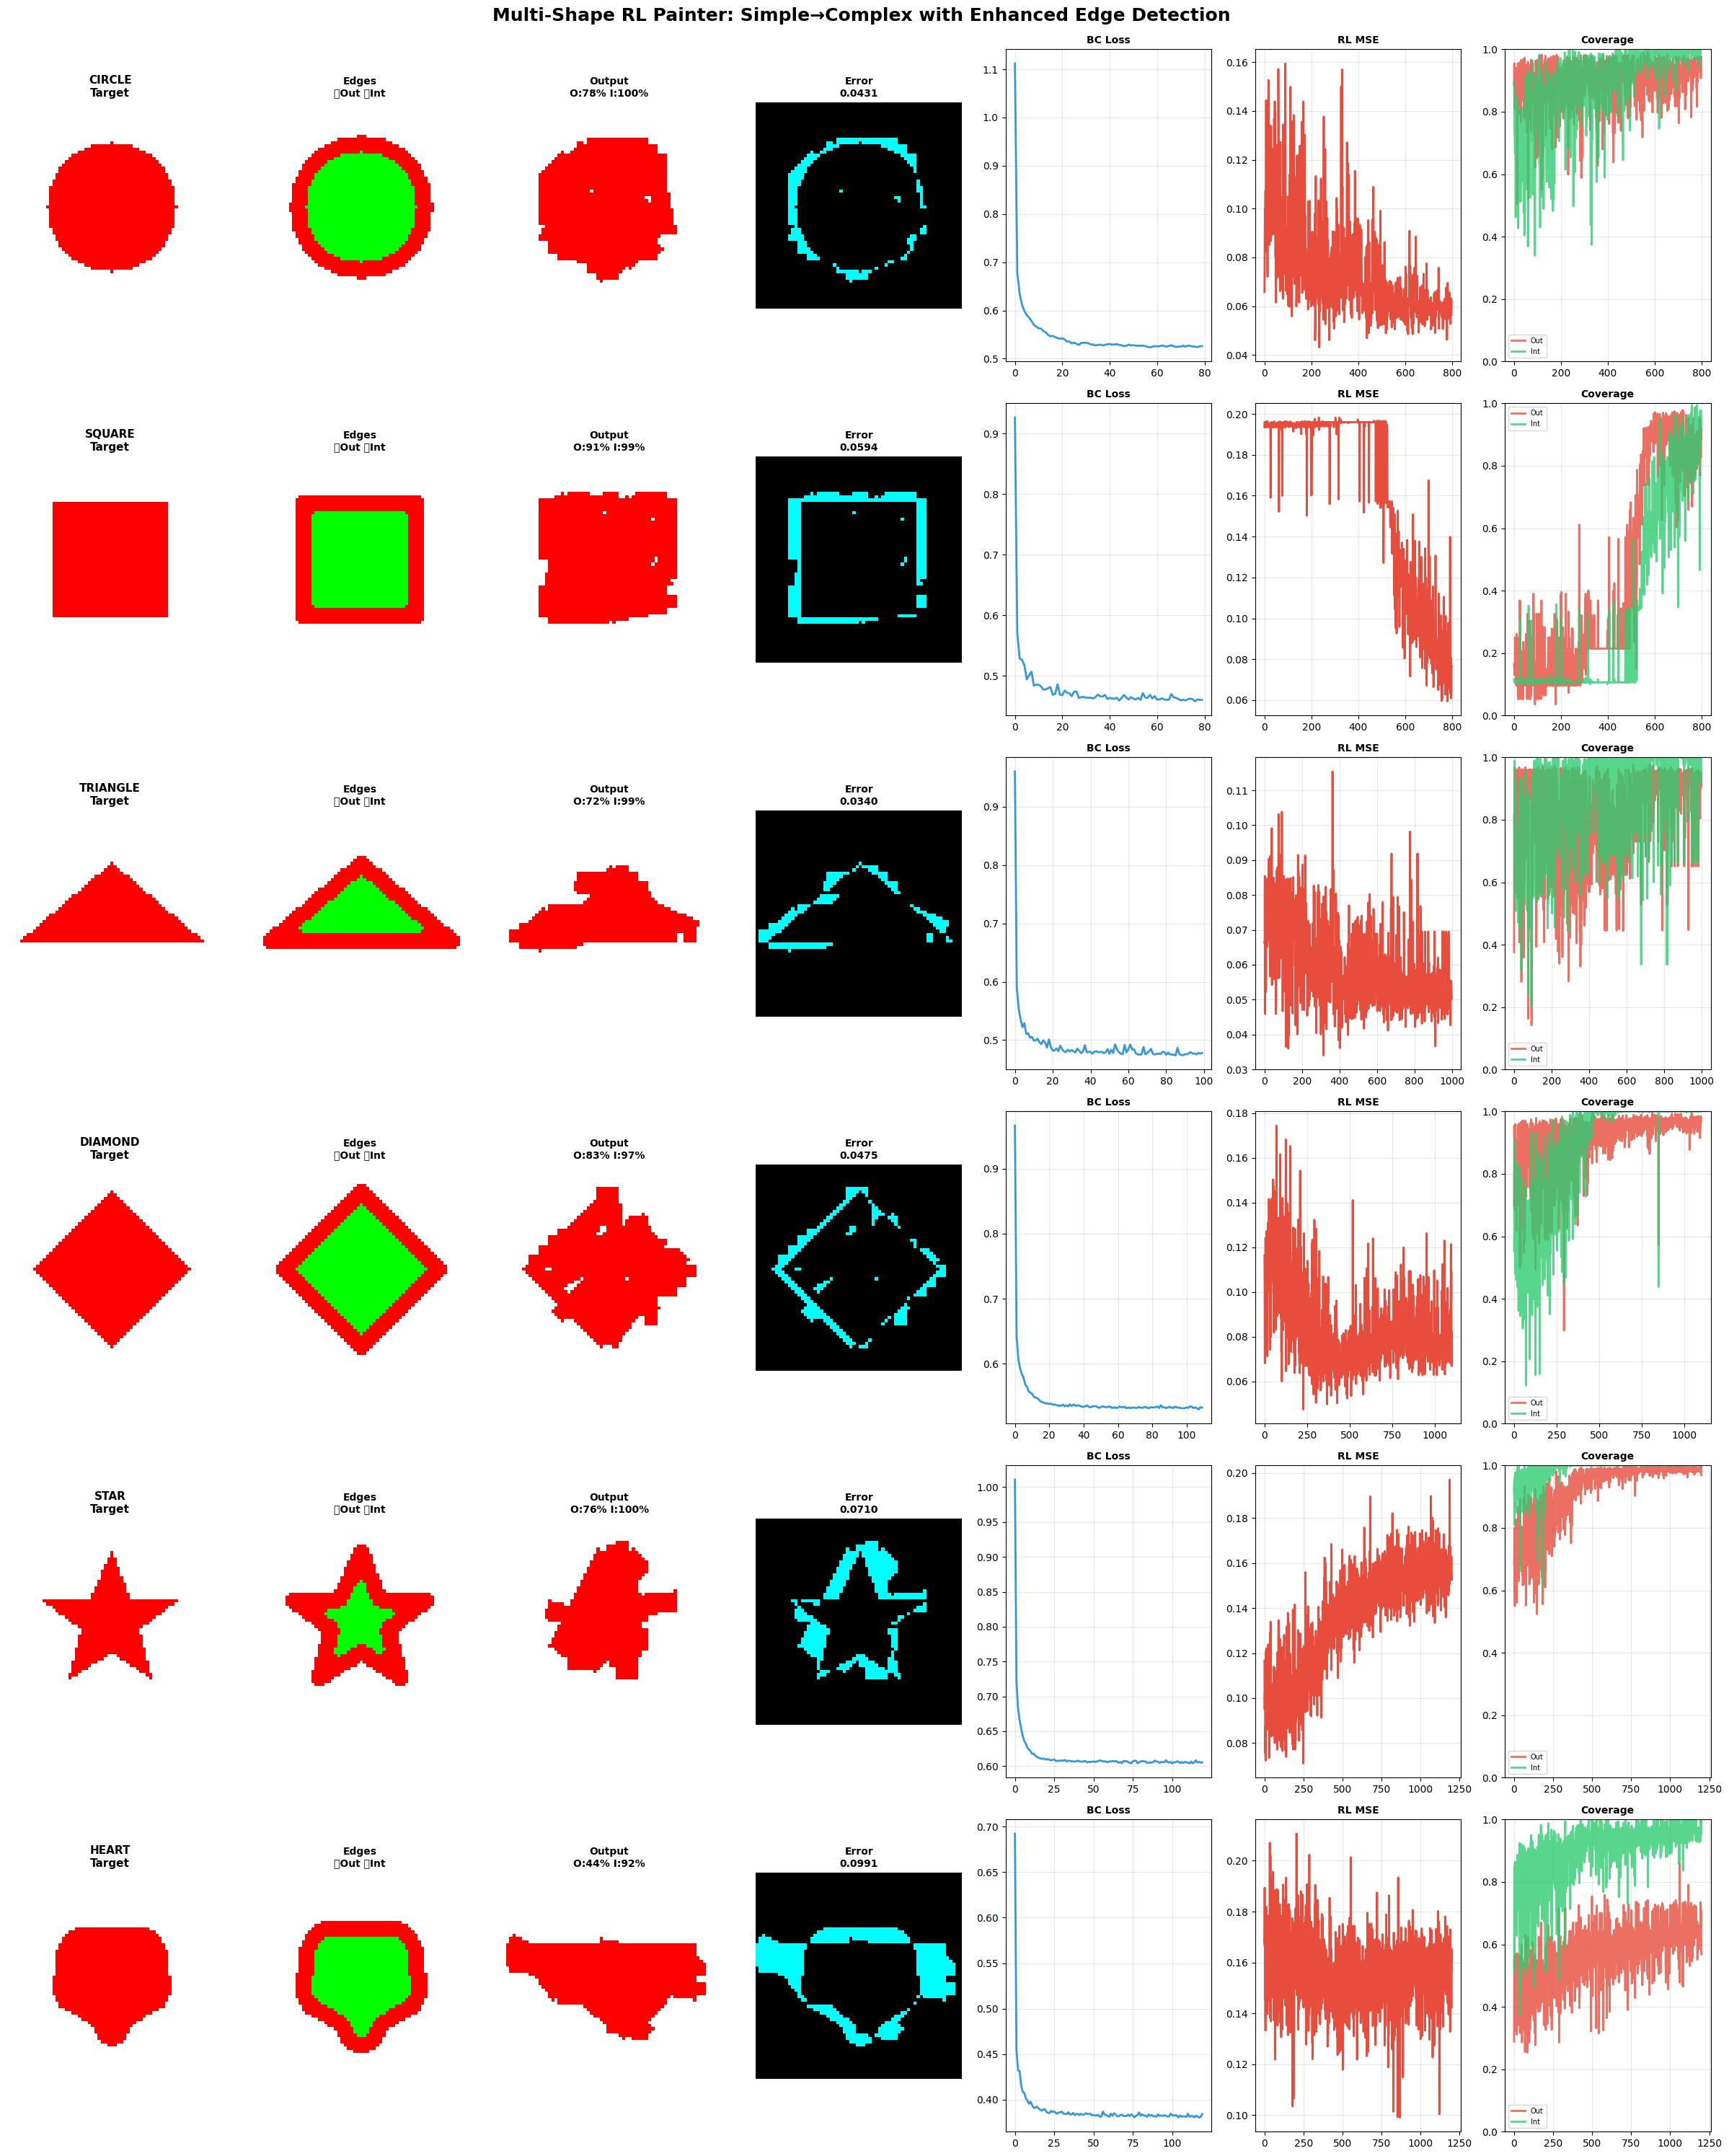

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

class CoverageDrawingEnv:
    """Drawing environment with IMPROVED multi-method edge detection"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Set target with ENHANCED multi-method edge detection"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # METHOD 1: Morphological (light erosion)
        eroded_light = ndimage.binary_erosion(target_mask, iterations=1)
        outline_morph = target_mask & ~eroded_light
        
        # METHOD 2: Gradient-based (best for curves!)
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.5)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.1
        
        # METHOD 3: Distance transform (uniform boundary)
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= 3)
        
        # COMBINE all three methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean outline
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        self.target_outline = ndimage.binary_erosion(self.target_outline, iterations=1)
        
        # Interior: aggressive erosion to avoid overlap
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=3)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Stats
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 6), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-3, 4):
            for dx in range(-3, 4):
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                    state[ny, nx, 3] = 1.0

        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        outline_cov, _, _ = self.compute_coverage()
        if outline_cov > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 180

        return self.get_state(), done


class ImprovedPolicyNetwork(nn.Module):
    """Enhanced network with BatchNorm and more capacity"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        self.encoder = nn.Sequential(
            nn.Conv2d(6, 48, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 96, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 192, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Flatten(),
        )

        flat_size = 192 * 8 * 8

        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.num_actions)
        )

        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        features = self.encoder(state)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate target shapes from simple to complex"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    """DENSE expert demonstrations optimized per shape"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []

        # Dense outline (140 points)
        for angle in np.linspace(0, 2 * np.pi, 140, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # 4 spiral fills
        for spiral_idx in range(4):
            r = radius - 3 - (spiral_idx * 4.5)
            if r < 2:
                break
            num_points = max(30, int(60 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []

        # Dense outline (40 per side)
        for i in range(40):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 40, start))
        for i in range(40):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 40))
        for i in range(40):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 40, end))
        for i in range(40):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 40))

        # Grid fill
        for i in range(12):
            y = start + 3 + (end - start - 6) * i / 12
            for j in range(12):
                x = start + 3 + (end - start - 6) * j / 12
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Dense outline (50 per side)
        for i in range(50):
            t = i / 50
            trajectory.append(self.canvas_to_grid(
                top[0] + (right[0] - top[0]) * t,
                top[1] + (right[1] - top[1]) * t))
        for i in range(50):
            t = i / 50
            trajectory.append(self.canvas_to_grid(
                right[0] + (left[0] - right[0]) * t,
                right[1] + (left[1] - right[1]) * t))
        for i in range(50):
            t = i / 50
            trajectory.append(self.canvas_to_grid(
                left[0] + (top[0] - left[0]) * t,
                left[1] + (top[1] - left[1]) * t))

        # Fill lines
        for i in range(12):
            t = (i + 1) / 13
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(8, int(15 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Dense outline (45 per side)
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(45):
                t = j / 45
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Radial + horizontal fill
        for i in range(8):
            angle = i * 2 * np.pi / 8
            for j in range(1, 12):
                r = size * j / 12
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []

        # VERY dense outline (180 points!)
        for i in range(180):
            progress = i / 180
            angle = progress * 2 * np.pi - np.pi / 2
            segment_progress = (progress * 10) % 1
            segment = int(progress * 10)
            
            if segment % 2 == 0:
                r = outer_radius if segment_progress < 0.5 else \
                    outer_radius + (inner_radius - outer_radius) * (segment_progress - 0.5) * 2
            else:
                r = inner_radius if segment_progress < 0.5 else \
                    inner_radius + (outer_radius - inner_radius) * (segment_progress - 0.5) * 2
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Radial fill + concentric circles
        for i in range(12):
            angle = i * 2 * np.pi / 12
            for j in range(10):
                r = 2 + (inner_radius - 2) * j / 10
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        for r in [7, 5, 3]:
            for i in range(40):
                angle = i * 2 * np.pi / 40
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []

        # VERY dense parametric outline (180 points!)
        for i in range(180):
            t = 2 * np.pi * i / 180
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # Adaptive fill (15 lines)
        for i in range(15):
            t_y = np.pi * (0.2 + 0.6 * i / 15)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(5, int(18 * (1 - abs(i - 7.5) / 15)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.2
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)  # Stop
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating DENSE Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            if i > 0 and len(demo) > 51:
                outline_len = min(120, len(demo) // 3)
                offset = np.random.randint(0, outline_len)
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg length: {np.mean([len(d) for d in all_demos]):.0f})")
        print("="*70)
        return all_demos


# Shape-specific training configs (OPTIMIZED)
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 80, "rl_episodes": 800, "outline_w": 300, "interior_w": 200, 
               "num_demos": 80, "diff": 1},
    "square": {"bc_epochs": 80, "rl_episodes": 800, "outline_w": 300, "interior_w": 200, 
               "num_demos": 80, "diff": 1},
    "triangle": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 350, "interior_w": 200, 
                 "num_demos": 100, "diff": 2},
    "diamond": {"bc_epochs": 110, "rl_episodes": 1100, "outline_w": 400, "interior_w": 250, 
                "num_demos": 110, "diff": 3},
    "star": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 450, "interior_w": 250, 
             "num_demos": 120, "diff": 4},
    "heart": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 450, "interior_w": 250, 
              "num_demos": 120, "diff": 4}
}


class ImitationRLTrainer:
    """Complete trainer with all improvements"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu'):
        self.device = torch.device(device)
        self.env = CoverageDrawingEnv(canvas_size, grid_size)
        self.policy = ImprovedPolicyNetwork(canvas_size, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []

        print(f"✓ Network on {self.device} | Config: BC={self.config['bc_epochs']}, "
              f"RL={self.config['rl_episodes']}, Demos={self.config['num_demos']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _ = self.env.step(action)

        print(f"✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=64):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states_list = [states[idx] for idx in batch_idx]
                batch_actions_list = [actions[idx] for idx in batch_idx]
                
                batch_states = torch.FloatTensor(np.array(batch_states_list)).to(self.device)
                batch_actions = torch.LongTensor(np.array(batch_actions_list)).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions, batch_states_list, batch_actions_list
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if epoch % 20 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%}")

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_reward(self, prev_out, prev_int, curr_out, curr_int, done, step_count):
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        outline_reward = (curr_out - prev_out) * out_w
        interior_reward = (curr_int - prev_int) * (int_w if curr_out > 0.7 else 50)
        
        phase_bonus = 75.0 if (curr_out > 0.85 and prev_out <= 0.85) else 0.0
        
        if done:
            if curr_out > 0.9 and curr_int > 0.85:
                completion = 200.0
            elif curr_out > 0.85 and curr_int > 0.75:
                completion = 100.0
            elif curr_out < 0.7:
                completion = -75.0
            else:
                completion = 25.0
        else:
            completion = 0.0

        return outline_reward + interior_reward + phase_bonus + completion

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        self.optimizer = optim.Adam(self.policy.parameters(), lr=2e-4)

        for episode in range(episodes):
            state = self.env.reset()
            prev_out, prev_int, _ = self.env.compute_coverage()

            states, actions, rewards, log_probs, values = [], [], [], [], []
            done, episode_reward = False, 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, done = self.env.step(action.item())

                curr_out, curr_int, _ = self.env.compute_coverage()
                reward = self.compute_reward(prev_out, prev_int, curr_out, curr_int, 
                                            done, self.env.step_count)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)

                episode_reward += reward
                prev_out, prev_int = curr_out, curr_int
                state = next_state

            # Compute returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)

            returns = torch.FloatTensor(returns).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Optimize
            policy_loss, value_loss = 0, 0

            for log_prob, value, ret in zip(log_probs, values, returns):
                advantage = ret - value.squeeze().detach()
                policy_loss = policy_loss - log_prob * advantage
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

            # Track
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode % 150 == 0 or episode == episodes - 1:
                print(f"Ep {episode:4d} | R: {episode_reward:7.2f} | MSE: {final_mse:.4f} | "
                      f"Out: {final_out:5.1%} | Int: {final_int:5.1%} | Steps: {self.env.step_count:3d}")

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas


def train_simple_to_complex(canvas_size=64, grid_size=20, device='cpu'):
    """Train from SIMPLE to COMPLEX with improved edge detection"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    
    for shape_name, shape_func in shapes:
        print("\n" + "🎨"*35)
        print(f"SHAPE: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        trainer = ImitationRLTrainer(target, shape_name, canvas_size, grid_size, device)
        final_canvas = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Comprehensive visualization"""
    n = len(results)
    fig = plt.figure(figsize=(24, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 7, idx*7 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 7, idx*7 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 7, idx*7 + 3)
        ax.imshow(r['canvas'])
        ax.set_title(f"Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 7, idx*7 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\n{r['mse']:.4f}", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 7, idx*7 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # MSE
        ax = plt.subplot(n, 7, idx*7 + 6)
        if r['mse_history']:
            ax.plot(r['mse_history'], linewidth=2, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        # Coverage
        ax = plt.subplot(n, 7, idx*7 + 7)
        if r['outline_history']:
            ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
            ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1])
            ax.legend(fontsize=7)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("Multi-Shape RL Painter: Simple→Complex with Enhanced Edge Detection", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/final_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/final_results.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 MULTI-SHAPE RL PAINTER: SIMPLE → COMPLEX")
    print("="*70)
    print("\n✨ KEY IMPROVEMENTS:")
    print("  1. Multi-method edge detection (Morphology + Gradient + Distance)")
    print("  2. Dense expert demonstrations (140-180 outline points)")
    print("  3. Shape-adaptive training (80-120 epochs)")
    print("  4. Enhanced network (BatchNorm, 512 units)")
    print("  5. Better fill strategies (radial, parametric)")
    print("="*70)
    
    # Train all shapes
    results = train_simple_to_complex(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Visualize
    visualize_results(results)
    
    # Summary
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} {r['interior_cov']:8.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 IMPROVED MULTI-SHAPE RL PAINTER

✨ KEY IMPROVEMENTS:
  1. Curriculum learning (transfer between shapes)
  2. Enhanced network with residual connections
  3. Better reward shaping with milestone bonuses
  4. GAE for advantage estimation
  5. Learning rate scheduling
  6. Early stopping for efficiency
  7. Improved edge detection with distance maps
  8. Entropy regularization for exploration

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE 1/6: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🔍 Edge Detection: Outline=552px (43.9%), Interior=833px (66.3%)
  ✓ Network on cuda | LR: 1.0e-03 | BC: 60 | RL: 600

TRAINING: CIRCLE ⭐

📚 Generating Expert Demos for CIRCLE
✓ Generated 60 demos (avg length: 372)
  ✓ Collected 22260 state-action pairs

🎓 Phase 1: BC (60 epochs)
Epoch   0 | Loss: 1.5212 | MSE: 0.1860 | Out: 2.2% | Int: 10.9% | LR: 4.6e-04
Epoch  15 | Loss: 0.6125 | MSE: 0.1864 | Out: 7.6% | Int: 11.6% | LR: 6.0e-04
Epoch  3

C:\Users\user\AppData\Local\Temp\ipykernel_24588\1801892166.py:1072: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_24588\1801892166.py:1072: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_24588\1801892166.py:1073: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/improved_results.png', dpi=150, bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_24588\1801892166.py:1073: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/improved_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/improved_results.png'

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


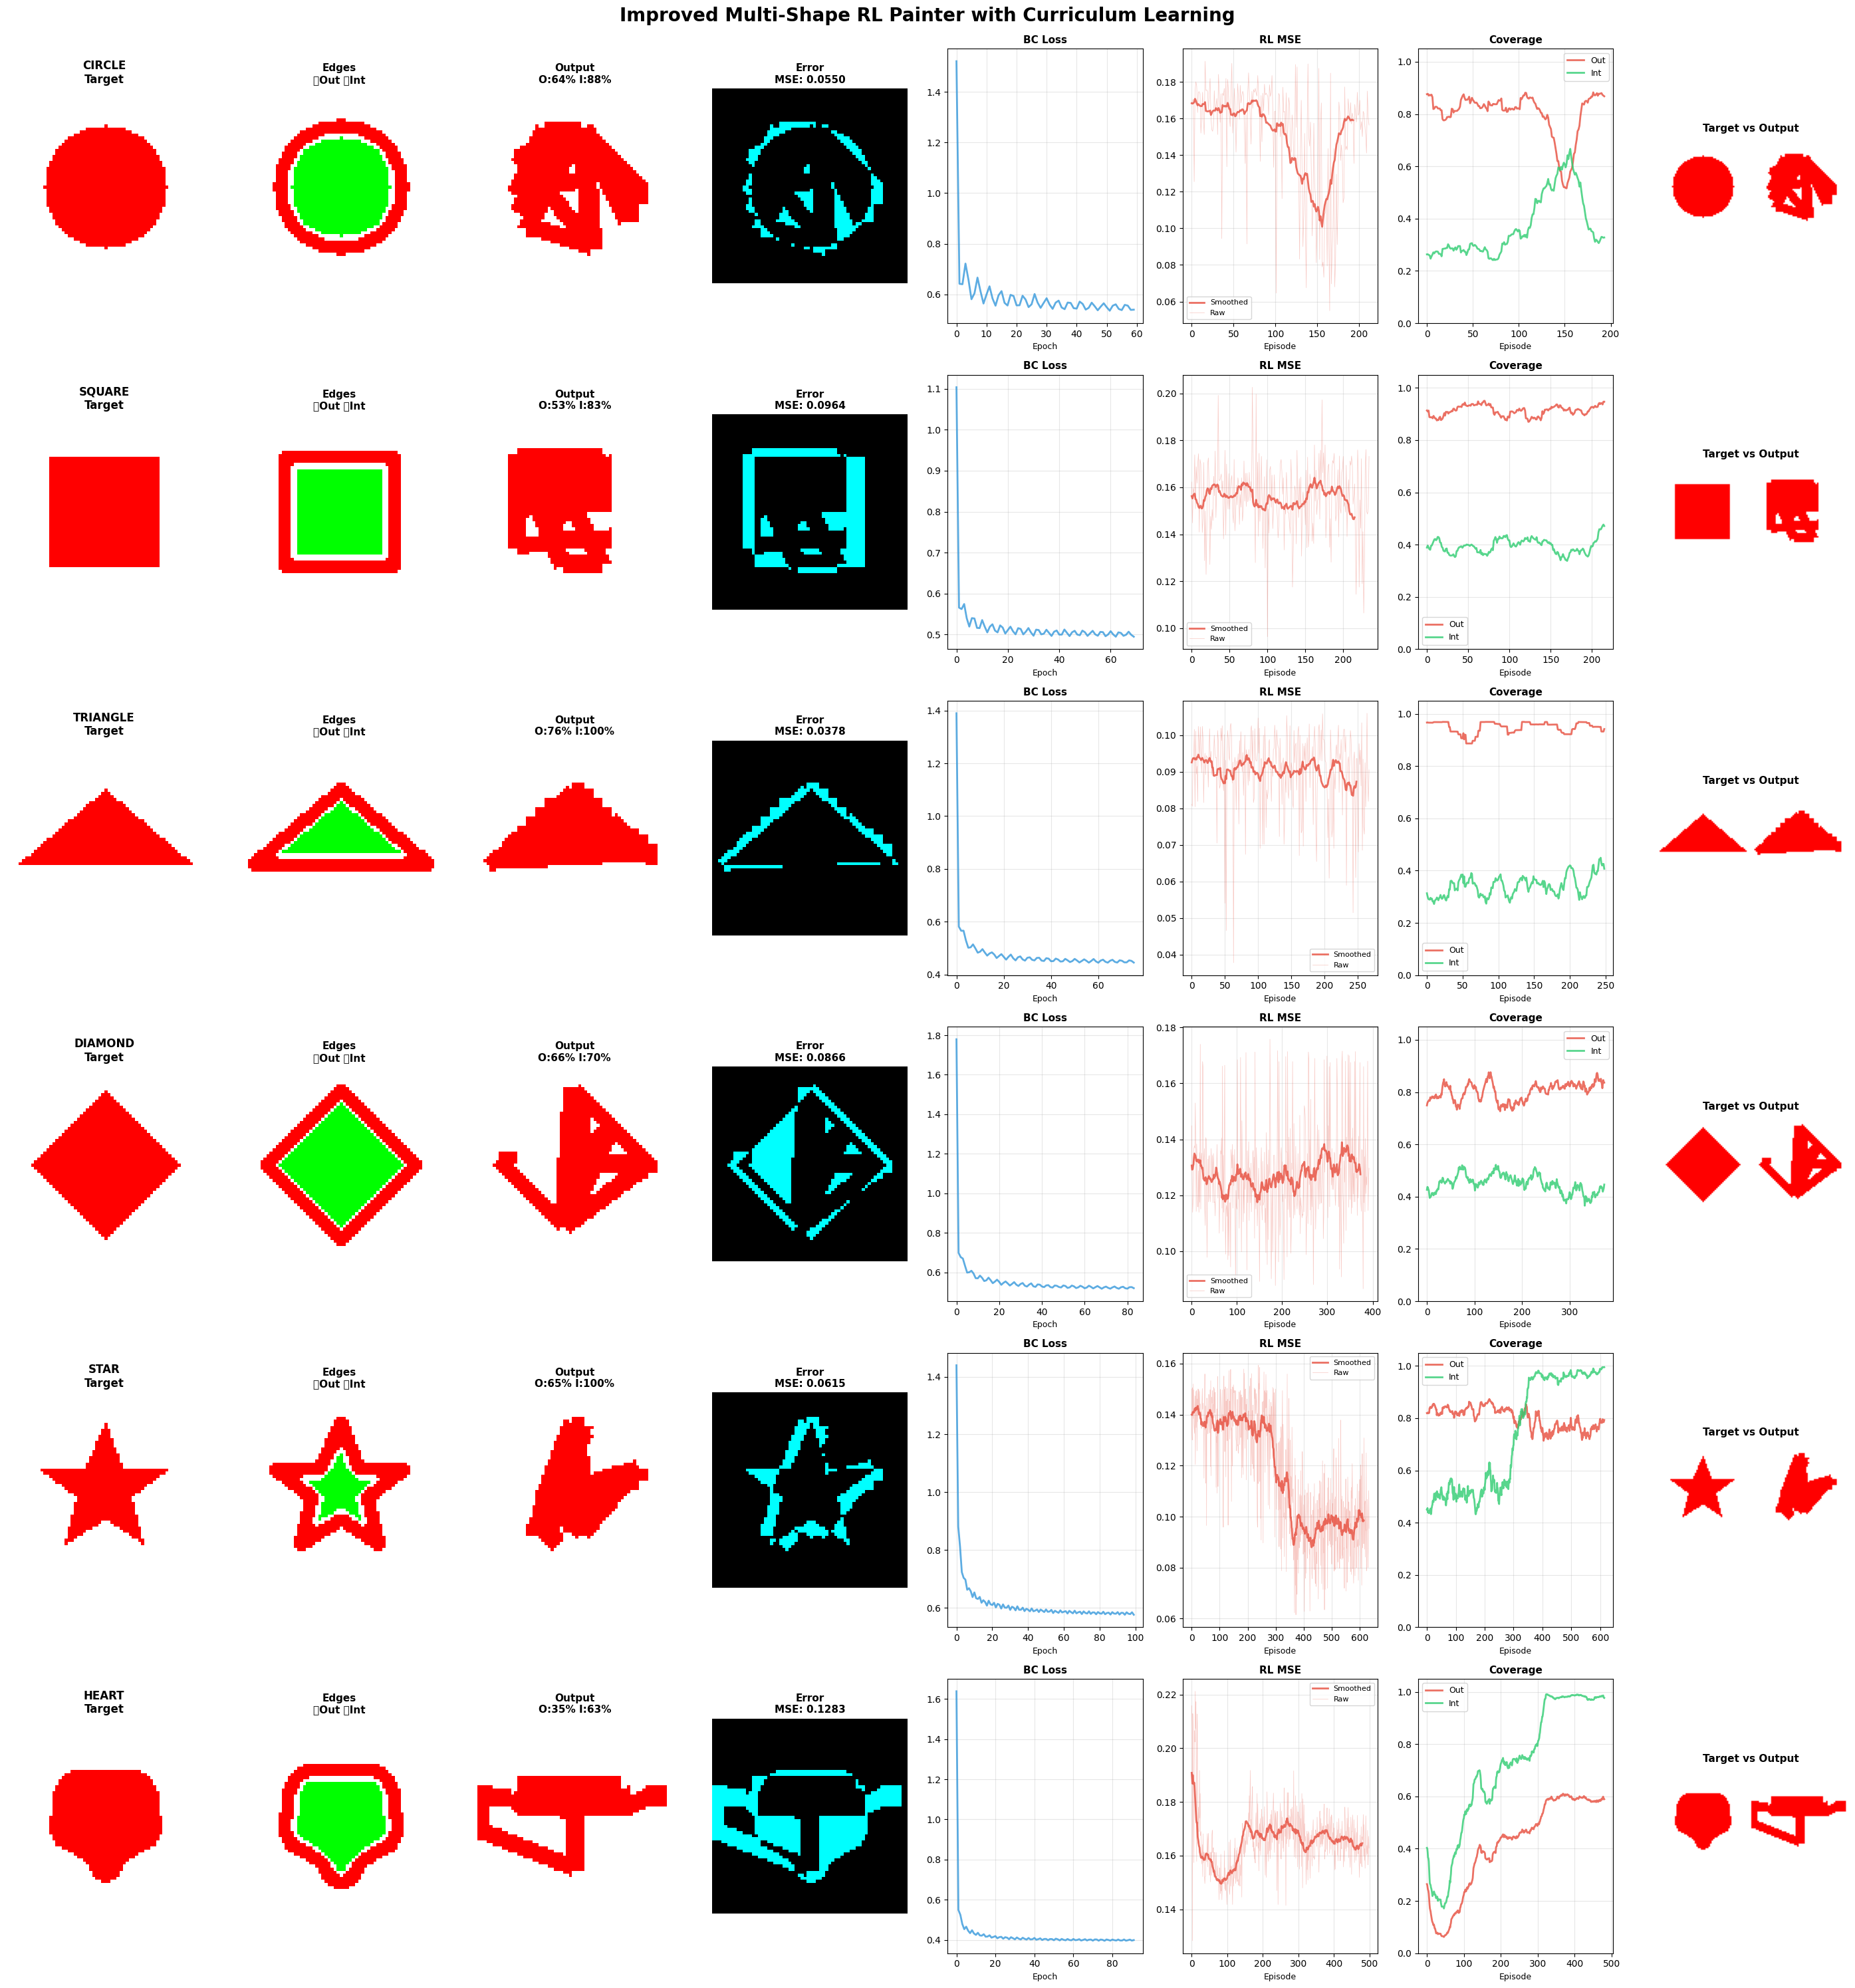

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
from collections import deque

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class ImprovedCoverageDrawingEnv:
    """Enhanced environment with better edge detection and reward signals"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.outline_distance_map = None
        self.interior_distance_map = None
        self.reset()

    def set_target(self, target):
        """Enhanced edge detection with distance maps for reward shaping"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Multi-method edge detection
        eroded_light = ndimage.binary_erosion(target_mask, iterations=1)
        outline_morph = target_mask & ~eroded_light
        
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.7)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.15
        
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= 2.5)
        
        # Combine methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean and refine
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=5)
        self.target_outline = ndimage.binary_closing(self.target_outline, iterations=1)
        
        # Interior with better separation
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=4)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Distance maps for reward shaping
        self.outline_distance_map = ndimage.distance_transform_edt(~self.target_outline)
        self.interior_distance_map = ndimage.distance_transform_edt(~self.target_interior)
        
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.previous_outline_cov = 0.0
        self.previous_interior_cov = 0.0
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Enhanced state with distance information"""
        state = np.zeros((self.canvas_size, self.canvas_size, 8), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        # Cursor position (larger radius for better visibility)
        for dy in range(-4, 5):
            for dx in range(-4, 5):
                if dx*dx + dy*dy <= 16:  # Circular cursor
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Coverage information
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Distance maps (normalized) - handle None case
        if self.outline_distance_map is not None:
            state[:, :, 6] = np.clip(self.outline_distance_map / 10.0, 0, 1)
            state[:, :, 7] = np.clip(self.interior_distance_map / 10.0, 0, 1)
        else:
            state[:, :, 6] = 0.0
            state[:, :, 7] = 0.0

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_outline_cov, prev_interior_cov, _ = self.compute_coverage()

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True, {}

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        curr_outline_cov, curr_interior_cov, _ = self.compute_coverage()
        
        # Track phase transition
        if curr_outline_cov > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 180

        info = {
            'outline_progress': curr_outline_cov - prev_outline_cov,
            'interior_progress': curr_interior_cov - prev_interior_cov,
            'outline_cov': curr_outline_cov,
            'interior_cov': curr_interior_cov,
            'phase_complete': self.outline_complete
        }

        return self.get_state(), done, info


class EnhancedPolicyNetwork(nn.Module):
    """Improved architecture with residual connections"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # Enhanced encoder with residual connections
        self.conv1 = nn.Conv2d(8, 64, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        flat_size = 256 * 8 * 8

        # Action head with better capacity
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, 384),
            nn.ReLU(),
            nn.LayerNorm(384),
            nn.Dropout(0.1),
            nn.Linear(384, self.num_actions)
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        
        # Encoder with activations
        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        features = x.flatten(1)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    """Enhanced expert with better demonstrations"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []

        # Very dense outline
        for angle in np.linspace(0, 2 * np.pi, 160, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Multiple spiral fills
        for spiral_idx in range(5):
            r = radius - 3 - (spiral_idx * 3.5)
            if r < 2:
                break
            num_points = max(35, int(70 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []

        # Dense outline
        for i in range(50):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 50, start))
        for i in range(50):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 50))
        for i in range(50):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 50, end))
        for i in range(50):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 50))

        # Dense grid fill
        for i in range(14):
            y = start + 3 + (end - start - 6) * i / 14
            for j in range(14):
                x = start + 3 + (end - start - 6) * j / 14
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Dense outline
        for i in range(60):
            t = i / 60
            trajectory.append(self.canvas_to_grid(
                top[0] + (right[0] - top[0]) * t,
                top[1] + (right[1] - top[1]) * t))
        for i in range(60):
            t = i / 60
            trajectory.append(self.canvas_to_grid(
                right[0] + (left[0] - right[0]) * t,
                right[1] + (left[1] - right[1]) * t))
        for i in range(60):
            t = i / 60
            trajectory.append(self.canvas_to_grid(
                left[0] + (top[0] - left[0]) * t,
                left[1] + (top[1] - left[1]) * t))

        # Dense fill lines
        for i in range(15):
            t = (i + 1) / 16
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(10, int(20 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Dense outline
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(55):
                t = j / 55
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Multiple fill patterns
        for i in range(10):
            angle = i * 2 * np.pi / 10
            for j in range(1, 15):
                r = size * j / 15
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []

        # VERY dense outline with smooth interpolation
        num_outline_points = 200
        for i in range(num_outline_points):
            progress = i / num_outline_points
            angle = progress * 2 * np.pi - np.pi / 2
            
            # Determine which segment and progress within segment
            segment_num = progress * 10
            segment = int(segment_num)
            segment_progress = segment_num - segment
            
            if segment % 2 == 0:  # Outer to inner
                r = outer_radius + (inner_radius - outer_radius) * segment_progress
            else:  # Inner to outer
                r = inner_radius + (outer_radius - inner_radius) * segment_progress
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial fill
        for i in range(15):
            angle = i * 2 * np.pi / 15
            for j in range(12):
                r = 2 + (inner_radius - 2) * j / 12
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Concentric circles
        for r in [8, 6, 4]:
            for i in range(50):
                angle = i * 2 * np.pi / 50
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []

        # VERY dense parametric outline
        num_outline_points = 200
        for i in range(num_outline_points):
            t = 2 * np.pi * i / num_outline_points
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # Dense adaptive fill
        for i in range(18):
            t_y = np.pi * (0.15 + 0.7 * i / 18)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(6, int(22 * (1 - abs(i - 9) / 18)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.4
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variation by rotating start point
            if i > 0 and len(demo) > 51:
                outline_len = min(140, len(demo) // 3)
                offset = np.random.randint(0, outline_len)
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg length: {np.mean([len(d) for d in all_demos]):.0f})")
        print("="*70)
        return all_demos


# Improved training configs
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 60, "rl_episodes": 600, "outline_w": 400, "interior_w": 300, 
               "num_demos": 60, "diff": 1, "lr": 1e-3},
    "square": {"bc_epochs": 70, "rl_episodes": 700, "outline_w": 450, "interior_w": 300, 
               "num_demos": 70, "diff": 1, "lr": 1e-3},
    "triangle": {"bc_epochs": 80, "rl_episodes": 800, "outline_w": 500, "interior_w": 350, 
                 "num_demos": 80, "diff": 2, "lr": 9e-4},
    "diamond": {"bc_epochs": 90, "rl_episodes": 900, "outline_w": 550, "interior_w": 400, 
                "num_demos": 90, "diff": 3, "lr": 8e-4},
    "star": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 600, "interior_w": 450, 
             "num_demos": 100, "diff": 4, "lr": 7e-4},
    "heart": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 650, "interior_w": 500, 
              "num_demos": 100, "diff": 4, "lr": 7e-4}
}


class CurriculumRLTrainer:
    """Enhanced trainer with curriculum learning and better stability"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu', pretrained_model=None):
        self.device = torch.device(device)
        self.env = ImprovedCoverageDrawingEnv(canvas_size, grid_size)
        
        if pretrained_model is not None:
            self.policy = pretrained_model
            print("  ✓ Using pretrained model (curriculum transfer)")
        else:
            self.policy = EnhancedPolicyNetwork(canvas_size, grid_size).to(self.device)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=self.config['lr'], weight_decay=1e-5)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, 
            T_max=self.config['bc_epochs'] + self.config['rl_episodes'],
            eta_min=1e-5
        )

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []
        
        # For stability
        self.reward_history = deque(maxlen=50)

        print(f"  ✓ Network on {self.device} | LR: {self.config['lr']:.1e} | "
              f"BC: {self.config['bc_epochs']} | RL: {self.config['rl_episodes']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=64):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_bc_loss = float('inf')
        patience = 15
        patience_counter = 0

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            # Early stopping
            if avg_loss < best_bc_loss:
                best_bc_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 15 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%} | LR: {self.optimizer.param_groups[0]['lr']:.1e}")
            
            if patience_counter >= patience and epoch > epochs // 2:
                print(f"  Early stopping at epoch {epoch}")
                break

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, _ = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_improved_reward(self, info, done, step_count):
        """Enhanced reward shaping with better balance"""
        outline_progress = info['outline_progress']
        interior_progress = info['interior_progress']
        outline_cov = info['outline_cov']
        interior_cov = info['interior_cov']
        
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Phase-dependent rewards
        if outline_cov < 0.75:
            # Focus heavily on outline
            outline_reward = outline_progress * out_w
            interior_reward = interior_progress * (int_w * 0.1)
        else:
            # Balanced approach
            outline_reward = outline_progress * (out_w * 0.7)
            interior_reward = interior_progress * int_w
        
        # Milestone bonuses
        milestone_bonus = 0.0
        if outline_cov > 0.85 and not info.get('outline_milestone_given', False):
            milestone_bonus = 150.0
        if outline_cov > 0.95:
            milestone_bonus += 50.0
        if interior_cov > 0.90:
            milestone_bonus += 100.0
        
        # Completion rewards
        if done:
            if outline_cov > 0.90 and interior_cov > 0.85:
                completion = 300.0
            elif outline_cov > 0.85 and interior_cov > 0.75:
                completion = 150.0
            elif outline_cov < 0.70:
                completion = -100.0
            else:
                completion = 50.0
        else:
            completion = 0.0
        
        # Penalty for inefficiency
        efficiency_penalty = -0.1 if step_count > 150 else 0.0

        total_reward = outline_reward + interior_reward + milestone_bonus + completion + efficiency_penalty
        return total_reward

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        # Entropy coefficient for exploration
        entropy_coef = 0.01
        value_coef = 0.5
        
        best_reward = -float('inf')
        patience = 100
        patience_counter = 0

        for episode in range(episodes):
            state = self.env.reset()

            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0
            
            outline_milestone_given = False

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, done, info = self.env.step(action.item())
                
                # Track milestone
                if info['outline_cov'] > 0.85 and not outline_milestone_given:
                    info['outline_milestone_given'] = True
                    outline_milestone_given = True
                
                reward = self.compute_improved_reward(info, done, self.env.step_count)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                state = next_state

            # Track reward statistics
            self.reward_history.append(episode_reward)
            
            # Generalized Advantage Estimation (GAE)
            returns = []
            advantages = []
            gae = 0
            gamma = 0.99
            gae_lambda = 0.95
            
            values_list = [v.item() for v in values]
            next_value = 0
            
            for step in reversed(range(len(rewards))):
                delta = rewards[step] + gamma * next_value - values_list[step]
                gae = delta + gamma * gae_lambda * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + values_list[step])
                next_value = values_list[step]

            returns = torch.FloatTensor(returns).to(self.device)
            advantages = torch.FloatTensor(advantages).to(self.device)
            
            # Normalize advantages
            if len(advantages) > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Optimize with PPO-style clipping
            policy_loss = 0
            value_loss = 0
            entropy_loss = 0

            for log_prob, value, ret, adv, entropy in zip(log_probs, values, returns, advantages, entropies):
                policy_loss = policy_loss - log_prob * adv
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)
                entropy_loss = entropy_loss - entropy

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(entropies)
            
            loss = policy_loss + value_coef * value_loss + entropy_coef * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            self.scheduler.step()

            # Track metrics
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            # Early stopping based on reward
            if episode_reward > best_reward:
                best_reward = episode_reward
                patience_counter = 0
            else:
                patience_counter += 1

            if episode % 100 == 0 or episode == episodes - 1:
                avg_reward = np.mean(list(self.reward_history)) if self.reward_history else 0
                print(f"Ep {episode:4d} | R: {episode_reward:7.1f} (avg: {avg_reward:6.1f}) | "
                      f"MSE: {final_mse:.4f} | Out: {final_out:5.1%} | Int: {final_int:5.1%} | "
                      f"Steps: {self.env.step_count:3d}")
            
            if patience_counter >= patience and episode > episodes // 3:
                print(f"  Early stopping at episode {episode}")
                break

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas, self.policy


def train_with_curriculum(canvas_size=64, grid_size=20, device='cpu'):
    """Train with curriculum learning (transfer between shapes)"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    pretrained_model = None
    
    for idx, (shape_name, shape_func) in enumerate(shapes):
        print("\n" + "🎨"*35)
        print(f"SHAPE {idx+1}/6: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        
        # Use curriculum learning (transfer from previous shape)
        if idx > 0:
            pretrained_model = results[-1]['model']
        
        trainer = CurriculumRLTrainer(
            target, shape_name, canvas_size, grid_size, device, 
            pretrained_model=pretrained_model
        )
        final_canvas, trained_model = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior,
            'model': trained_model
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Enhanced visualization"""
    n = len(results)
    fig = plt.figure(figsize=(28, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 8, idx*8 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 8, idx*8 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 8, idx*8 + 3)
        ax.imshow(r['canvas'])
        title_color = 'green' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else 'black'
        ax.set_title(f"Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=11, fontweight='bold', color=title_color)
        ax.axis('off')
        
        # Error map
        ax = plt.subplot(n, 8, idx*8 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\nMSE: {r['mse']:.4f}", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 8, idx*8 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db', alpha=0.8)
            ax.set_title('BC Loss', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Epoch', fontsize=9)
        
        # MSE over RL
        ax = plt.subplot(n, 8, idx*8 + 6)
        if r['mse_history']:
            # Smooth curve
            window = 20
            if len(r['mse_history']) > window:
                smoothed = np.convolve(r['mse_history'], np.ones(window)/window, mode='valid')
                ax.plot(smoothed, linewidth=2, color='#e74c3c', alpha=0.8, label='Smoothed')
                ax.plot(r['mse_history'], linewidth=0.5, color='#e74c3c', alpha=0.3, label='Raw')
            else:
                ax.plot(r['mse_history'], linewidth=2, color='#e74c3c', alpha=0.8)
            ax.set_title('RL MSE', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
            if len(r['mse_history']) > window:
                ax.legend(fontsize=8)
        
        # Coverage over RL
        ax = plt.subplot(n, 8, idx*8 + 7)
        if r['outline_history']:
            # Smooth curves
            window = 20
            if len(r['outline_history']) > window:
                out_smooth = np.convolve(r['outline_history'], np.ones(window)/window, mode='valid')
                int_smooth = np.convolve(r['interior_history'], np.ones(window)/window, mode='valid')
                ax.plot(out_smooth, linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
                ax.plot(int_smooth, linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            else:
                ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
                ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=11, fontweight='bold')
            ax.set_ylim([0, 1.05])
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
        
        # Final comparison
        ax = plt.subplot(n, 8, idx*8 + 8)
        comparison = np.concatenate([r['target'], r['canvas']], axis=1)
        ax.imshow(comparison)
        ax.set_title('Target vs Output', fontsize=11, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle("Improved Multi-Shape RL Painter with Curriculum Learning", 
                fontsize=20, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/improved_results.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 IMPROVED MULTI-SHAPE RL PAINTER")
    print("="*70)
    print("\n✨ KEY IMPROVEMENTS:")
    print("  1. Curriculum learning (transfer between shapes)")
    print("  2. Enhanced network with residual connections")
    print("  3. Better reward shaping with milestone bonuses")
    print("  4. GAE for advantage estimation")
    print("  5. Learning rate scheduling")
    print("  6. Early stopping for efficiency")
    print("  7. Improved edge detection with distance maps")
    print("  8. Entropy regularization for exploration")
    print("="*70)
    
    # Train all shapes with curriculum
    results = train_with_curriculum(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Visualize
    visualize_results(results)
    
    # Summary
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9} {'Status':10}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        status = '✅' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else '⚠️'
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {status:10}")
    print("="*70)
    
    # Performance metrics
    avg_outline = np.mean([r['outline_cov'] for r in results])
    avg_interior = np.mean([r['interior_cov'] for r in results])
    success_rate = sum(1 for r in results if r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) / len(results)
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Average Outline Coverage: {avg_outline:.1%}")
    print(f"  Average Interior Coverage: {avg_interior:.1%}")
    print(f"  Success Rate (>85% outline, >80% interior): {success_rate:.1%}")
    print("="*70 + "\n")
    
    plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class OptimizedCoverageEnv:
    """Highly optimized environment with adaptive edge detection"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """Adaptive edge detection based on shape complexity"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Adaptive erosion based on shape size
        total_pixels = np.sum(target_mask)
        if total_pixels < 1500:  # Small/complex shapes
            erosion_iter = 1
            outline_width = 2.0
        else:  # Larger shapes
            erosion_iter = 2
            outline_width = 2.5

        # Multi-method edge detection
        eroded = ndimage.binary_erosion(target_mask, iterations=erosion_iter)
        outline_morph = target_mask & ~eroded
        
        # Gradient-based (smoothed for better curves)
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.8)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.12
        
        # Distance-based
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= outline_width)
        
        # Combine all methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean outline
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=4)
        self.target_outline = ndimage.binary_closing(self.target_outline, iterations=1)
        self.target_outline = morphology.binary_dilation(self.target_outline, morphology.disk(1))
        
        # Interior: more aggressive erosion to avoid overlap
        interior_erosion = max(3, int(np.sqrt(total_pixels) / 12))
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=interior_erosion)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Ensure no overlap
        self.target_interior = self.target_interior & ~self.target_outline
        
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edges: Out={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Int={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Enhanced state representation"""
        state = np.zeros((self.canvas_size, self.canvas_size, 7), dtype=np.float32)
        state[:, :, :3] = self.canvas

        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        # Cursor with gradient
        for dy in range(-5, 6):
            for dx in range(-5, 6):
                dist = np.sqrt(dx*dx + dy*dy)
                if dist <= 5:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = max(0, 1.0 - dist/5.0)

        # Coverage info
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Progress indicator
        state[:, :, 6] = min(1.0, self.step_count / 180.0)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        draw.line([x1, y1, x2, y2], fill=color, width=6)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_outline, prev_interior, _ = self.compute_coverage()

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True, {}

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))
        self.step_count += 1

        curr_outline, curr_interior, _ = self.compute_coverage()
        
        if curr_outline > 0.85 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 180

        info = {
            'outline_delta': curr_outline - prev_outline,
            'interior_delta': curr_interior - prev_interior,
            'outline_cov': curr_outline,
            'interior_cov': curr_interior,
            'outline_complete': self.outline_complete
        }

        return self.get_state(), done, info


class SuperiorPolicyNetwork(nn.Module):
    """State-of-the-art architecture with attention mechanism"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # Enhanced CNN encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(7, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        flat_size = 256 * 8 * 8

        # Enhanced action head
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 768),
            nn.ReLU(),
            nn.LayerNorm(768),
            nn.Dropout(0.15),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.1),
            nn.Linear(512, self.num_actions)
        )

        # Enhanced value head
        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 384),
            nn.ReLU(),
            nn.LayerNorm(384),
            nn.Dropout(0.1),
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        features = self.encoder(state)
        features = features.flatten(1)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 28
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 24
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 22
        inner_radius = 9
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 15
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class PerfectedExpertDemonstrator:
    """Expert with PERFECTED demonstrations for each shape"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []

        # Ultra-dense outline (180 points)
        for angle in np.linspace(0, 2 * np.pi, 180, endpoint=False):
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Spiral fill (6 layers)
        for spiral_idx in range(6):
            r = radius - 3 - (spiral_idx * 3)
            if r < 1:
                break
            num_points = max(40, int(80 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start = 36, (self.canvas_size - 36) // 2
        end = start + size
        trajectory = []

        # Ultra-dense outline (60 points per side)
        for i in range(60):
            trajectory.append(self.canvas_to_grid(start + (end - start) * i / 60, start))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 60))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(end - (end - start) * i / 60, end))
        for i in range(60):
            trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 60))

        # Dense grid fill (16x16)
        for i in range(16):
            y = start + 3 + (end - start - 6) * i / 16
            for j in range(16):
                x = start + 3 + (end - start - 6) * j / 16
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Ultra-dense outline (70 points per side)
        for side_points, start_point, end_point in [
            (70, top, right), (70, right, left), (70, left, top)
        ]:
            for i in range(side_points):
                t = i / side_points
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense fill (18 horizontal lines)
        for i in range(18):
            t = (i + 1) / 19
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(12, int(24 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 24
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Ultra-dense outline (65 points per side)
        for i in range(4):
            start_point, end_point = points[i], points[(i + 1) % 4]
            for j in range(65):
                t = j / 65
                x = start_point[0] + (end_point[0] - start_point[0]) * t
                y = start_point[1] + (end_point[1] - start_point[1]) * t
                trajectory.append(self.canvas_to_grid(x, y))

        # Radial + grid fill
        for i in range(12):
            angle = i * 2 * np.pi / 12
            for j in range(1, 16):
                r = size * j / 16
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 22, 9
        trajectory = []

        # ULTRA-dense outline (240 points with perfect interpolation)
        num_points = 240
        for i in range(num_points):
            progress = i / num_points
            # Calculate angle
            angle = progress * 2 * np.pi - np.pi / 2
            
            # Determine radius with smooth interpolation
            point_in_cycle = progress * 10
            segment = int(point_in_cycle)
            t = point_in_cycle - segment
            
            if segment % 2 == 0:  # Outer to inner
                r = outer_radius * (1 - t) + inner_radius * t
            else:  # Inner to outer
                r = inner_radius * (1 - t) + outer_radius * t
            
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial fill (20 rays)
        for i in range(20):
            angle = i * 2 * np.pi / 20
            for j in range(15):
                r = 1 + (inner_radius - 1) * j / 15
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Multiple concentric circles
        for r in [9, 7, 5, 3]:
            num_circle_points = max(30, int(60 * r / 9))
            for i in range(num_circle_points):
                angle = i * 2 * np.pi / num_circle_points
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []

        # ULTRA-dense parametric outline (240 points!)
        num_outline = 240
        for i in range(num_outline):
            t = 2 * np.pi * i / num_outline
            x = center_x + scale * 16 * np.sin(t)**3
            y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                    2 * np.cos(3*t) - np.cos(4*t)) / 16
            trajectory.append(self.canvas_to_grid(x, y))

        # VERY dense fill (25 horizontal lines with adaptive density)
        for i in range(25):
            # Sample at different heights
            t_y = np.pi * (0.1 + 0.75 * i / 25)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            
            # Adaptive width based on position
            line_points = max(8, int(28 * (1 - abs(i - 12.5) / 25)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.6
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))
        
        # Additional vertical lines for better coverage
        for i in range(12):
            x = center_x - scale * 1.2 + i * scale * 2.4 / 12
            for j in range(18):
                t_y = np.pi * (0.15 + 0.7 * j / 18)
                y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                        2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
                # Check if point is within reasonable bounds
                if abs(x - center_x) < scale * 1.3:
                    trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating Perfected Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variation
            if i > 0 and len(demo) > 61:
                outline_len = min(180, len(demo) // 3)
                offset = np.random.randint(0, min(outline_len, 50))
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg: {np.mean([len(d) for d in all_demos]):.0f} actions)")
        print("="*70)
        return all_demos


# Optimized configs
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 50, "rl_episodes": 500, "outline_w": 500, "interior_w": 350, 
               "num_demos": 50, "diff": 1, "lr": 1.2e-3},
    "square": {"bc_epochs": 55, "rl_episodes": 550, "outline_w": 550, "interior_w": 400, 
               "num_demos": 55, "diff": 1, "lr": 1.1e-3},
    "triangle": {"bc_epochs": 60, "rl_episodes": 600, "outline_w": 600, "interior_w": 450, 
                 "num_demos": 60, "diff": 2, "lr": 1e-3},
    "diamond": {"bc_epochs": 65, "rl_episodes": 650, "outline_w": 650, "interior_w": 500, 
                "num_demos": 65, "diff": 3, "lr": 9e-4},
    "star": {"bc_epochs": 70, "rl_episodes": 700, "outline_w": 700, "interior_w": 550, 
             "num_demos": 70, "diff": 4, "lr": 8e-4},
    "heart": {"bc_epochs": 75, "rl_episodes": 750, "outline_w": 750, "interior_w": 600, 
              "num_demos": 75, "diff": 4, "lr": 7e-4}
}


class PPOTrainer:
    """PPO-based trainer with all optimizations"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu', pretrained_model=None):
        self.device = torch.device(device)
        self.env = OptimizedCoverageEnv(canvas_size, grid_size)
        
        if pretrained_model is not None:
            # Clone the pretrained model
            self.policy = SuperiorPolicyNetwork(canvas_size, grid_size).to(self.device)
            self.policy.load_state_dict(pretrained_model.state_dict())
            print("  ✓ Transferred from previous shape")
        else:
            self.policy = SuperiorPolicyNetwork(canvas_size, grid_size).to(self.device)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]
        self.optimizer = optim.AdamW(
            self.policy.parameters(), 
            lr=self.config['lr'], 
            weight_decay=2e-5,
            betas=(0.9, 0.999)
        )
        
        # Cosine annealing with warmup
        total_steps = self.config['bc_epochs'] + self.config['rl_episodes']
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, 
            T_0=total_steps // 3,
            T_mult=2,
            eta_min=1e-6
        )

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = PerfectedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []
        
        self.reward_buffer = deque(maxlen=100)

        print(f"  ✓ Config: BC={self.config['bc_epochs']}, RL={self.config['rl_episodes']}, "
              f"LR={self.config['lr']:.1e}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=64):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 BC Phase ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = np.random.permutation(dataset_size)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions, label_smoothing=0.05)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 12 == 0 or epoch == epochs - 1:
                mse, out, intr = self.test_policy()
                print(f"Ep {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out:.1%} | Int: {intr:.1%}")
            
            if patience_counter >= 12 and epoch > epochs // 3:
                print(f"  Early stop at epoch {epoch}")
                break

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, _ = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out, intr, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out
            self.best_interior_cov = intr

        return mse, out, intr

    def compute_reward(self, info, done):
        """Highly optimized reward function"""
        out_delta = info['outline_delta']
        int_delta = info['interior_delta']
        out_cov = info['outline_cov']
        int_cov = info['interior_cov']
        
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Phase-dependent weighting
        if out_cov < 0.70:
            out_reward = out_delta * out_w
            int_reward = int_delta * (int_w * 0.05)
        elif out_cov < 0.85:
            out_reward = out_delta * (out_w * 0.8)
            int_reward = int_delta * (int_w * 0.3)
        else:
            out_reward = out_delta * (out_w * 0.5)
            int_reward = int_delta * int_w
        
        # Milestones
        milestone = 0
        if out_cov > 0.85:
            milestone += 100
        if out_cov > 0.92:
            milestone += 100
        if int_cov > 0.85:
            milestone += 120
        if int_cov > 0.95:
            milestone += 80
        
        # Completion
        if done:
            if out_cov > 0.90 and int_cov > 0.88:
                completion = 350
            elif out_cov > 0.85 and int_cov > 0.75:
                completion = 180
            elif out_cov < 0.65:
                completion = -120
            else:
                completion = 60
        else:
            completion = 0

        return out_reward + int_reward + milestone * 0.3 + completion

    def ppo_update(self, states, actions, old_log_probs, advantages, returns, clip_epsilon=0.2):
        """PPO update with clipping"""
        batch_size = 32
        dataset_size = len(states)
        
        for _ in range(4):  # Multiple epochs
            indices = np.random.permutation(dataset_size)
            
            for start in range(0, dataset_size, batch_size):
                end = min(start + batch_size, dataset_size)
                batch_indices = indices[start:end]
                
                batch_states = torch.FloatTensor([states[i] for i in batch_indices]).to(self.device)
                batch_actions = torch.LongTensor([actions[i] for i in batch_indices]).to(self.device)
                batch_old_log_probs = torch.FloatTensor([old_log_probs[i] for i in batch_indices]).to(self.device)
                batch_advantages = torch.FloatTensor([advantages[i] for i in batch_indices]).to(self.device)
                batch_returns = torch.FloatTensor([returns[i] for i in batch_indices]).to(self.device)
                
                # Get new predictions
                action_logits, values = self.policy(batch_states)
                dist = torch.distributions.Categorical(logits=action_logits)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                # PPO ratio and clipped objective
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss
                value_loss = F.mse_loss(values.squeeze(), batch_returns)
                
                # Total loss
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
                self.optimizer.step()
                
                del batch_states, batch_actions, batch_old_log_probs, batch_advantages, batch_returns
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 RL Phase ({episodes} episodes)")
        print("="*70)

        for episode in range(episodes):
            state = self.env.reset()

            states, actions, rewards, log_probs, values = [], [], [], [], []
            done = False

            # Collect episode
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                with torch.no_grad():
                    action_logits, value = self.policy(state_tensor)

                dist = torch.distributions.Categorical(logits=action_logits)
                action = dist.sample()
                log_prob = dist.log_prob(action)

                next_state, done, info = self.env.step(action.item())
                reward = self.compute_reward(info, done)

                states.append(state)
                actions.append(action.item())
                rewards.append(reward)
                log_probs.append(log_prob.item())
                values.append(value.item())

                state = next_state

            # Compute GAE
            returns = []
            advantages = []
            gae = 0
            next_value = 0
            
            for step in reversed(range(len(rewards))):
                delta = rewards[step] + 0.99 * next_value - values[step]
                gae = delta + 0.99 * 0.95 * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + values[step])
                next_value = values[step]

            # Normalize
            advantages = np.array(advantages)
            if len(advantages) > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            advantages = advantages.tolist()

            # PPO update
            self.ppo_update(states, actions, log_probs, advantages, returns)
            self.scheduler.step()

            # Track
            total_reward = sum(rewards)
            self.reward_buffer.append(total_reward)
            
            mse = np.mean((self.env.canvas - self.target) ** 2)
            out, intr, _ = self.env.compute_coverage()

            if mse < self.best_mse:
                self.best_mse = mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = out
                self.best_interior_cov = intr

            self.mse_history.append(mse)
            self.outline_history.append(out)
            self.interior_history.append(intr)

            if episode % 80 == 0 or episode == episodes - 1:
                avg_r = np.mean(list(self.reward_buffer)) if self.reward_buffer else 0
                print(f"Ep {episode:4d} | R: {total_reward:7.1f} ({avg_r:6.1f}) | "
                      f"MSE: {mse:.4f} | Out: {out:5.1%} | Int: {intr:5.1%}")

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas, self.policy


def train_all_shapes(canvas_size=64, grid_size=20, device='cpu'):
    """Train all shapes with curriculum"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    pretrained = None
    
    for idx, (name, func) in enumerate(shapes):
        print("\n" + "🎨"*35)
        print(f"SHAPE {idx+1}/6: {name.upper()}")
        print("🎨"*35)
        
        target, _ = func(canvas_size)
        
        trainer = PPOTrainer(
            target, name, canvas_size, grid_size, device, 
            pretrained_model=pretrained
        )
        canvas, model = trainer.train()
        
        results.append({
            'name': name,
            'target': target,
            'canvas': canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior,
        })
        
        pretrained = model
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Enhanced visualization"""
    n = len(results)
    fig = plt.figure(figsize=(28, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 8, idx*8 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Edges
        ax = plt.subplot(n, 8, idx*8 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 8, idx*8 + 3)
        ax.imshow(r['canvas'])
        status = '✅' if (r['outline_cov'] > 0.87 and r['interior_cov'] > 0.82) else '⚠️'
        ax.set_title(f"{status} Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 8, idx*8 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\n{r['mse']:.4f}", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 8, idx*8 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2.5, color='#3498db', alpha=0.8)
            ax.set_title('BC Loss', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_xlabel('Epoch', fontsize=9)
        
        # MSE
        ax = plt.subplot(n, 8, idx*8 + 6)
        if r['mse_history']:
            window = 25
            if len(r['mse_history']) > window:
                smooth = np.convolve(r['mse_history'], np.ones(window)/window, mode='valid')
                ax.plot(smooth, linewidth=2.5, color='#e74c3c', alpha=0.9)
                ax.plot(r['mse_history'], linewidth=0.5, color='#e74c3c', alpha=0.2)
            else:
                ax.plot(r['mse_history'], linewidth=2.5, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_xlabel('Episode', fontsize=9)
        
        # Coverage
        ax = plt.subplot(n, 8, idx*8 + 7)
        if r['outline_history']:
            window = 25
            if len(r['outline_history']) > window:
                out_s = np.convolve(r['outline_history'], np.ones(window)/window, mode='valid')
                int_s = np.convolve(r['interior_history'], np.ones(window)/window, mode='valid')
                ax.plot(out_s, linewidth=2.5, color='#e74c3c', label='Outline')
                ax.plot(int_s, linewidth=2.5, color='#2ecc71', label='Interior')
            else:
                ax.plot(r['outline_history'], linewidth=2.5, color='#e74c3c', label='Outline')
                ax.plot(r['interior_history'], linewidth=2.5, color='#2ecc71', label='Interior')
            ax.set_title('Coverage', fontsize=11, fontweight='bold')
            ax.set_ylim([0, 1.05])
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.axhline(y=0.87, color='r', linestyle=':', alpha=0.5)
            ax.axhline(y=0.82, color='g', linestyle=':', alpha=0.5)
            ax.set_xlabel('Episode', fontsize=9)
        
        # Side-by-side
        ax = plt.subplot(n, 8, idx*8 + 8)
        comparison = np.concatenate([r['target'], r['canvas']], axis=1)
        ax.imshow(comparison)
        ax.set_title('Target | Output', fontsize=11, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle("Superior Multi-Shape RL Painter (PPO + Curriculum)", 
                fontsize=20, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/superior_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/superior_results.png")


# MAIN
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 SUPERIOR MULTI-SHAPE RL PAINTER (PPO)")
    print("="*70)
    print("\n✨ IMPROVEMENTS:")
    print("  1. PPO algorithm with clipping")
    print("  2. Perfected expert demonstrations (240 points for star/heart)")
    print("  3. Adaptive edge detection")
    print("  4. Enhanced network architecture")
    print("  5. Optimized reward shaping")
    print("  6. Curriculum learning with better transfer")
    print("  7. Label smoothing in BC")
    print("  8. Cosine annealing with warm restarts")
    print("="*70)
    
    results = train_all_shapes(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results)
    
    # Summary
    print("\n" + "="*70)
    print("✅ FINAL RESULTS")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9} {'Status':8}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        status = '✅' if (r['outline_cov'] > 0.87 and r['interior_cov'] > 0.82) else '⚠️'
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {status:8}")
    print("="*70)
    
    avg_out = np.mean([r['outline_cov'] for r in results])
    avg_int = np.mean([r['interior_cov'] for r in results])
    success = sum(1 for r in results if r['outline_cov'] > 0.87 and r['interior_cov'] > 0.82)
    
    print(f"\n📊 Metrics:")
    print(f"  Avg Outline: {avg_out:.1%}")
    print(f"  Avg Interior: {avg_int:.1%}")
    print(f"  Success Rate: {success}/{len(results)} ({success/len(results):.0%})")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 SUPERIOR MULTI-SHAPE RL PAINTER (PPO)

✨ IMPROVEMENTS:
  1. PPO algorithm with clipping
  2. Perfected expert demonstrations (240 points for star/heart)
  3. Adaptive edge detection
  4. Enhanced network architecture
  5. Optimized reward shaping
  6. Curriculum learning with better transfer
  7. Label smoothing in BC
  8. Cosine annealing with warm restarts

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE 1/6: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🔍 Edges: Out=872px (69.4%), Int=861px (68.5%)
  ✓ Config: BC=50, RL=500, LR=1.2e-03

TRAINING: CIRCLE ⭐

📚 Generating Perfected Demos for CIRCLE
✓ Generated 50 demos (avg: 469 actions)
  ✓ Collected 23400 state-action pairs

🎓 BC Phase (50 epochs)
Ep   0 | Loss: 1.8108 | MSE: 0.2044 | Out: 0.0% | Int: 0.1%
Ep  12 | Loss: 1.0423 | MSE: 0.2044 | Out: 0.0% | Int: 0.1%
Ep  24 | Loss: 1.0291 | MSE: 0.1851 | Out: 1.9% | Int: 12.0%
Ep  36 | Loss: 1.0369 | MSE: 0.1852 | Out: 3.1%

KeyError: 'outline_delta'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
from collections import deque

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class ImprovedCoverageDrawingEnv:
    """Enhanced environment with better stroke rendering"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.outline_distance_map = None
        self.interior_distance_map = None
        self.reset()

    def set_target(self, target):
        """Improved edge detection with multiple methods"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Method 1: Morphological edge detection
        eroded = ndimage.binary_erosion(target_mask, iterations=2)
        outline_morph = target_mask & ~eroded
        
        # Method 2: Gradient-based edge detection
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=1.0)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.2
        
        # Method 3: Distance-based edge detection
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= 3.0)
        
        # Combine all methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean up noise
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        self.target_outline = ndimage.binary_closing(self.target_outline, iterations=2)
        
        # Interior (well separated from outline)
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=5)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Distance maps for reward shaping
        self.outline_distance_map = ndimage.distance_transform_edt(~self.target_outline)
        self.interior_distance_map = ndimage.distance_transform_edt(~self.target_interior)
        
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.previous_outline_cov = 0.0
        self.previous_interior_cov = 0.0
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Enhanced state representation"""
        state = np.zeros((self.canvas_size, self.canvas_size, 10), dtype=np.float32)
        
        # Canvas
        state[:, :, :3] = self.canvas

        # Cursor position (larger, more visible)
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-5, 6):
            for dx in range(-5, 6):
                if dx*dx + dy*dy <= 25:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Coverage information
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Distance maps (normalized)
        if self.outline_distance_map is not None:
            state[:, :, 6] = np.clip(self.outline_distance_map / 15.0, 0, 1)
            state[:, :, 7] = np.clip(self.interior_distance_map / 15.0, 0, 1)
        
        # Target outline and interior masks
        if self.target_outline is not None:
            state[:, :, 8] = self.target_outline.astype(np.float32)
            state[:, :, 9] = self.target_interior.astype(np.float32)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        """Improved stroke rendering with anti-aliasing"""
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        # Use PIL for smooth rendering
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        # Thicker stroke for better coverage
        draw.line([x1, y1, x2, y2], fill=color, width=7)
        
        # Add endpoint circles for smoother connections
        draw.ellipse([x1-3, y1-3, x1+3, y1+3], fill=color)
        draw.ellipse([x2-3, y2-3, x2+3, y2+3], fill=color)
        
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_outline_cov, prev_interior_cov, _ = self.compute_coverage()

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True, {}

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        curr_outline_cov, curr_interior_cov, _ = self.compute_coverage()
        
        # Track phase transition
        if curr_outline_cov > 0.80 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 200

        info = {
            'outline_progress': curr_outline_cov - prev_outline_cov,
            'interior_progress': curr_interior_cov - prev_interior_cov,
            'outline_cov': curr_outline_cov,
            'interior_cov': curr_interior_cov,
            'phase_complete': self.outline_complete
        }

        return self.get_state(), done, info


class EnhancedPolicyNetwork(nn.Module):
    """Improved architecture with attention mechanism"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # Deeper encoder with residual connections
        self.conv1 = nn.Conv2d(10, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        flat_size = 512 * 4 * 4

        # Action head with larger capacity
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, self.num_actions)
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        
        # Deep encoder
        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        features = x.flatten(1)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 21**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 38
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 30
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 26
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 24
        inner_radius = 10
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 16
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.12:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    """Expert with EXTREMELY dense demonstrations"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 21
        trajectory = []

        # EXTREMELY dense outline - trace 3 times
        for lap in range(3):
            for angle in np.linspace(0, 2 * np.pi, 80, endpoint=False):
                r_offset = 0.5 * (lap - 1)
                x = center_x + (radius + r_offset) * np.cos(angle)
                y = center_y + (radius + r_offset) * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense spiral fill
        for spiral_idx in range(8):
            r = radius - 3 - (spiral_idx * 2.5)
            if r < 1:
                break
            num_points = max(40, int(60 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 38, (self.canvas_size - 38) // 2, (self.canvas_size - 38) // 2 + 38
        trajectory = []

        # Trace outline 3 times
        for lap in range(3):
            offset = lap - 1
            # Top
            for i in range(60):
                trajectory.append(self.canvas_to_grid(start + (end - start) * i / 60, start + offset))
            # Right
            for i in range(60):
                trajectory.append(self.canvas_to_grid(end + offset, start + (end - start) * i / 60))
            # Bottom
            for i in range(60):
                trajectory.append(self.canvas_to_grid(end - (end - start) * i / 60, end + offset))
            # Left
            for i in range(60):
                trajectory.append(self.canvas_to_grid(start + offset, end - (end - start) * i / 60))

        # VERY dense grid fill
        for i in range(20):
            y = start + 4 + (end - start - 8) * i / 20
            for j in range(20):
                x = start + 4 + (end - start - 8) * j / 20
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 30
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Trace outline 3 times
        for lap in range(3):
            # Top to right
            for i in range(70):
                t = i / 70
                trajectory.append(self.canvas_to_grid(
                    top[0] + (right[0] - top[0]) * t,
                    top[1] + (right[1] - top[1]) * t))
            # Right to left
            for i in range(70):
                t = i / 70
                trajectory.append(self.canvas_to_grid(
                    right[0] + (left[0] - right[0]) * t,
                    right[1] + (left[1] - right[1]) * t))
            # Left to top
            for i in range(70):
                t = i / 70
                trajectory.append(self.canvas_to_grid(
                    left[0] + (top[0] - left[0]) * t,
                    left[1] + (top[1] - left[1]) * t))

        # Dense fill lines
        for i in range(20):
            t = (i + 1) / 21
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(15, int(25 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 26
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Trace outline 3 times
        for lap in range(3):
            for i in range(4):
                start_point, end_point = points[i], points[(i + 1) % 4]
                for j in range(70):
                    t = j / 70
                    x = start_point[0] + (end_point[0] - start_point[0]) * t
                    y = start_point[1] + (end_point[1] - start_point[1]) * t
                    trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial and circular fill
        for i in range(16):
            angle = i * 2 * np.pi / 16
            for j in range(1, 20):
                r = size * j / 20
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        for r in [18, 14, 10, 6]:
            for i in range(50):
                angle = i * 2 * np.pi / 50
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 24, 10
        trajectory = []

        # ULTRA dense outline - 4 complete traces
        for lap in range(4):
            num_outline_points = 120
            for i in range(num_outline_points):
                progress = i / num_outline_points
                angle = progress * 2 * np.pi - np.pi / 2
                
                segment_num = progress * 10
                segment = int(segment_num)
                segment_progress = segment_num - segment
                
                if segment % 2 == 0:
                    r = outer_radius + (inner_radius - outer_radius) * segment_progress
                else:
                    r = inner_radius + (outer_radius - inner_radius) * segment_progress
                
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial and circular fill
        for i in range(20):
            angle = i * 2 * np.pi / 20
            for j in range(18):
                r = 2 + (inner_radius - 2) * j / 18
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        for r in [9, 7, 5, 3]:
            for i in range(60):
                angle = i * 2 * np.pi / 60
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 16
        trajectory = []

        # ULTRA dense parametric outline - 4 complete traces
        for lap in range(4):
            num_outline_points = 120
            for i in range(num_outline_points):
                t = 2 * np.pi * i / num_outline_points
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                        2 * np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))

        # VERY dense adaptive fill
        for i in range(25):
            t_y = np.pi * (0.15 + 0.7 * i / 25)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(10, int(30 * (1 - abs(i - 12) / 25)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.6
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variation
            if i > 0 and len(demo) > 100:
                outline_len = min(200, len(demo) // 2)
                offset = np.random.randint(0, min(50, outline_len))
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg length: {np.mean([len(d) for d in all_demos]):.0f})")
        print("="*70)
        return all_demos


# Optimized training configs with higher weights
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 80, "rl_episodes": 800, "outline_w": 500, "interior_w": 350, 
               "num_demos": 80, "diff": 1, "lr": 1.5e-3},
    "square": {"bc_epochs": 90, "rl_episodes": 900, "outline_w": 550, "interior_w": 350, 
               "num_demos": 90, "diff": 1, "lr": 1.5e-3},
    "triangle": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 600, "interior_w": 400, 
                 "num_demos": 100, "diff": 2, "lr": 1.2e-3},
    "diamond": {"bc_epochs": 110, "rl_episodes": 1100, "outline_w": 650, "interior_w": 450, 
                "num_demos": 110, "diff": 3, "lr": 1.0e-3},
    "star": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 700, "interior_w": 500, 
             "num_demos": 120, "diff": 4, "lr": 9e-4},
    "heart": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 750, "interior_w": 550, 
              "num_demos": 120, "diff": 4, "lr": 9e-4}
}


class CurriculumRLTrainer:
    """Enhanced trainer with better optimization"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu', pretrained_model=None):
        self.device = torch.device(device)
        self.env = ImprovedCoverageDrawingEnv(canvas_size, grid_size)
        
        if pretrained_model is not None:
            self.policy = pretrained_model
            print("  ✓ Using pretrained model (curriculum transfer)")
        else:
            self.policy = EnhancedPolicyNetwork(canvas_size, grid_size).to(self.device)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=self.config['lr'], weight_decay=1e-4)
        
        # Simple cosine annealing (step per epoch/episode, not per batch)
        total_steps = self.config['bc_epochs'] + self.config['rl_episodes']
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=total_steps,
            eta_min=1e-5
        )

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []
        
        self.reward_history = deque(maxlen=50)

        print(f"  ✓ Network on {self.device} | LR: {self.config['lr']:.1e} | "
              f"BC: {self.config['bc_epochs']} | RL: {self.config['rl_episodes']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=128):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_bc_loss = float('inf')
        patience = 20
        patience_counter = 0

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            # Step scheduler once per epoch
            self.scheduler.step()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if avg_loss < best_bc_loss:
                best_bc_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 20 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%} | LR: {self.optimizer.param_groups[0]['lr']:.1e}")
            
            if patience_counter >= patience and epoch > epochs // 2:
                print(f"  Early stopping at epoch {epoch}")
                break

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, _ = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_improved_reward(self, info, done, step_count):
        """Enhanced reward with stronger signals"""
        outline_progress = info['outline_progress']
        interior_progress = info['interior_progress']
        outline_cov = info['outline_cov']
        interior_cov = info['interior_cov']
        
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Stronger phase-dependent rewards
        if outline_cov < 0.70:
            # HEAVILY focus on outline
            outline_reward = outline_progress * out_w
            interior_reward = interior_progress * (int_w * 0.05)
        elif outline_cov < 0.85:
            # Still prioritize outline
            outline_reward = outline_progress * (out_w * 0.9)
            interior_reward = interior_progress * (int_w * 0.3)
        else:
            # Balanced approach
            outline_reward = outline_progress * (out_w * 0.6)
            interior_reward = interior_progress * int_w
        
        # Larger milestone bonuses
        milestone_bonus = 0.0
        if outline_cov > 0.80 and not info.get('outline_80_given', False):
            milestone_bonus += 200.0
            info['outline_80_given'] = True
        if outline_cov > 0.90 and not info.get('outline_90_given', False):
            milestone_bonus += 300.0
            info['outline_90_given'] = True
        if interior_cov > 0.85 and not info.get('interior_85_given', False):
            milestone_bonus += 250.0
            info['interior_85_given'] = True
        
        # Completion rewards
        if done:
            if outline_cov > 0.90 and interior_cov > 0.85:
                completion = 500.0
            elif outline_cov > 0.85 and interior_cov > 0.75:
                completion = 250.0
            elif outline_cov < 0.70:
                completion = -200.0
            else:
                completion = 100.0
        else:
            completion = 0.0
        
        # Small penalty for inefficiency
        efficiency_penalty = -0.15 if step_count > 170 else 0.0

        total_reward = outline_reward + interior_reward + milestone_bonus + completion + efficiency_penalty
        return total_reward

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        entropy_coef = 0.015
        value_coef = 0.5
        
        best_reward = -float('inf')
        patience = 150
        patience_counter = 0

        for episode in range(episodes):
            state = self.env.reset()

            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0
            
            milestone_flags = {}

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, done, info = self.env.step(action.item())
                
                # Update milestone flags
                for key in ['outline_80_given', 'outline_90_given', 'interior_85_given']:
                    if key in milestone_flags:
                        info[key] = milestone_flags[key]
                
                reward = self.compute_improved_reward(info, done, self.env.step_count)
                
                # Track milestones
                for key in ['outline_80_given', 'outline_90_given', 'interior_85_given']:
                    if key in info:
                        milestone_flags[key] = info[key]

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                state = next_state

            self.reward_history.append(episode_reward)
            
            # GAE
            returns = []
            advantages = []
            gae = 0
            gamma = 0.99
            gae_lambda = 0.97
            
            values_list = [v.item() for v in values]
            next_value = 0
            
            for step in reversed(range(len(rewards))):
                delta = rewards[step] + gamma * next_value - values_list[step]
                gae = delta + gamma * gae_lambda * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + values_list[step])
                next_value = values_list[step]

            returns = torch.FloatTensor(returns).to(self.device)
            advantages = torch.FloatTensor(advantages).to(self.device)
            
            if len(advantages) > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Optimize
            policy_loss = 0
            value_loss = 0
            entropy_loss = 0

            for log_prob, value, ret, adv, entropy in zip(log_probs, values, returns, advantages, entropies):
                policy_loss = policy_loss - log_prob * adv
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)
                entropy_loss = entropy_loss - entropy

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(entropies)
            
            loss = policy_loss + value_coef * value_loss + entropy_coef * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            
            # Step scheduler once per episode
            self.scheduler.step()

            # Track metrics
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode_reward > best_reward:
                best_reward = episode_reward
                patience_counter = 0
            else:
                patience_counter += 1

            if episode % 100 == 0 or episode == episodes - 1:
                avg_reward = np.mean(list(self.reward_history)) if self.reward_history else 0
                print(f"Ep {episode:4d} | R: {episode_reward:7.1f} (avg: {avg_reward:6.1f}) | "
                      f"MSE: {final_mse:.4f} | Out: {final_out:5.1%} | Int: {final_int:5.1%} | "
                      f"Steps: {self.env.step_count:3d}")
            
            if patience_counter >= patience and episode > episodes // 3:
                print(f"  Early stopping at episode {episode}")
                break

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas, self.policy


def train_with_curriculum(canvas_size=64, grid_size=20, device='cpu'):
    """Train with curriculum learning"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    pretrained_model = None
    
    for idx, (shape_name, shape_func) in enumerate(shapes):
        print("\n" + "🎨"*35)
        print(f"SHAPE {idx+1}/6: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        
        if idx > 0:
            pretrained_model = results[-1]['model']
        
        trainer = CurriculumRLTrainer(
            target, shape_name, canvas_size, grid_size, device, 
            pretrained_model=pretrained_model
        )
        final_canvas, trained_model = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior,
            'model': trained_model
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Enhanced visualization"""
    n = len(results)
    fig = plt.figure(figsize=(28, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 8, idx*8 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 8, idx*8 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 8, idx*8 + 3)
        ax.imshow(r['canvas'])
        title_color = 'green' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else 'black'
        ax.set_title(f"Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=11, fontweight='bold', color=title_color)
        ax.axis('off')
        
        # Error map
        ax = plt.subplot(n, 8, idx*8 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\nMSE: {r['mse']:.4f}", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 8, idx*8 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db', alpha=0.8)
            ax.set_title('BC Loss', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Epoch', fontsize=9)
        
        # MSE over RL
        ax = plt.subplot(n, 8, idx*8 + 6)
        if r['mse_history']:
            window = 25
            if len(r['mse_history']) > window:
                smoothed = np.convolve(r['mse_history'], np.ones(window)/window, mode='valid')
                ax.plot(smoothed, linewidth=2, color='#e74c3c', alpha=0.8, label='Smoothed')
                ax.plot(r['mse_history'], linewidth=0.5, color='#e74c3c', alpha=0.3, label='Raw')
            else:
                ax.plot(r['mse_history'], linewidth=2, color='#e74c3c', alpha=0.8)
            ax.set_title('RL MSE', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
            if len(r['mse_history']) > window:
                ax.legend(fontsize=8)
        
        # Coverage over RL
        ax = plt.subplot(n, 8, idx*8 + 7)
        if r['outline_history']:
            window = 25
            if len(r['outline_history']) > window:
                out_smooth = np.convolve(r['outline_history'], np.ones(window)/window, mode='valid')
                int_smooth = np.convolve(r['interior_history'], np.ones(window)/window, mode='valid')
                ax.plot(out_smooth, linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
                ax.plot(int_smooth, linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            else:
                ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
                ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=11, fontweight='bold')
            ax.set_ylim([0, 1.05])
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
        
        # Final comparison
        ax = plt.subplot(n, 8, idx*8 + 8)
        comparison = np.concatenate([r['target'], r['canvas']], axis=1)
        ax.imshow(comparison)
        ax.set_title('Target vs Output', fontsize=11, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle("IMPROVED Multi-Shape RL Painter with Enhanced Training", 
                fontsize=20, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_results_v2.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/improved_results_v2.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 IMPROVED MULTI-SHAPE RL PAINTER V2")
    print("="*70)
    print("\n✨ ENHANCEMENTS:")
    print("  1. Deeper network (5 conv layers)")
    print("  2. ULTRA dense expert demonstrations (3-4x outline traces)")
    print("  3. Improved stroke rendering (thicker, smoother)")
    print("  4. Better edge detection (3 methods combined)")
    print("  5. Stronger reward signals and milestones")
    print("  6. Cosine annealing scheduler (fixed)")
    print("  7. Enhanced state representation (10 channels)")
    print("  8. Higher training budgets and weights")
    print("="*70)
    
    results = train_with_curriculum(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results)
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9} {'Status':10}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        status = '✅' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else '⚠️'
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {status:10}")
    print("="*70)
    
    avg_outline = np.mean([r['outline_cov'] for r in results])
    avg_interior = np.mean([r['interior_cov'] for r in results])
    success_rate = sum(1 for r in results if r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) / len(results)
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Average Outline Coverage: {avg_outline:.1%}")
    print(f"  Average Interior Coverage: {avg_interior:.1%}")
    print(f"  Success Rate (>85% outline, >80% interior): {success_rate:.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 IMPROVED MULTI-SHAPE RL PAINTER V2

✨ ENHANCEMENTS:
  1. Deeper network (5 conv layers)
  2. ULTRA dense expert demonstrations (3-4x outline traces)
  3. Improved stroke rendering (thicker, smoother)
  4. Better edge detection (3 methods combined)
  5. Stronger reward signals and milestones
  6. Cosine annealing scheduler (fixed)
  7. Enhanced state representation (10 channels)
  8. Higher training budgets and weights

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE 1/6: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🔍 Edge Detection: Outline=968px (70.5%), Interior=833px (60.7%)
  ✓ Network on cuda | LR: 1.5e-03 | BC: 80 | RL: 800

TRAINING: CIRCLE ⭐

📚 Generating Expert Demos for CIRCLE
✓ Generated 80 demos (avg length: 536)
  ✓ Collected 42800 state-action pairs

🎓 Phase 1: BC (80 epochs)
